In [ ]:
#Installing the libraries
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d arashnic/earthquake-magnitude-damage-and-impact
! unzip earthquake-magnitude-damage-and-impact

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 97% 69.0M/71.1M [00:02<00:00, 30.9MB/s]
100% 71.1M/71.1M [00:02<00:00, 28.4MB/s]
Archive:  earthquake-magnitude-damage-and-impact.zip
  inflating: csv_building_damage_assessment.csv  
  inflating: csv_building_ownership_and_use.csv  
  inflating: csv_building_structure.csv  
  inflating: csv_household_demographics.csv  
  inflating: csv_household_earthquake_impact.csv  
  inflating: csv_household_resources.csv  
  inflating: csv_individual_demographics.csv  
  inflating: mapping.csv             
  inflating: ward_vdcmun_district_name_mapping.csv  


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [ ]:
# Pandas SQL
!pip install pandasql
import pandasql as ps

# time module 
import time

# SQLite RDBMS
import sqlite3

  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26781 sha256=392d9674152b0cac146c7b3fd282eb650a2b85e360173ca2b838aabd4f26de70
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


## **Before Running ....**

In order to run the following cells, please upload the kaggle.json file.

### **We aim to solve 2 Prediction Problems which have been arranged in 2 separate parts as may be seen below.**




## **PART 1**
## **Predicting Damage Grade from Buidling Structures**

The intent of this problem statement is to classify building structures vulnerable to Earthquakes.The dataset provides various tables containing
information about the building structures and the damages caused by the earthquake to these buidings. We intend to find insights which will help in assessing the level of damage that an earthquake can
cause to a certain building. By using the information provided in the dataset about the initial structures of the buildings and the damage grade of that buidling we aim to classify the building structures which are vulnerable and unsafe.

The tables being considered are: 

*   Building Ownership And Use Table
*   Building damage assessment Table
*   Building structure Table


**I. Cleaning and EDA for Building Ownership and Use Table**

**Columns in this table and some important metadata information**
1. Building ID - Each building has a unique ID 
2. District ID - Based on the location of the house of the individual
3. VDC MUN ID - In Nepal, districts are subdivided into localities known as Village Development Committees (VDCs)
4. Ward ID - Each VDC is further subdivided into wards and each ward has been allocated a unique number in this dataset. 
5. Legal ownership status - It has categorical values representing the how is the building owned.
6. Count of Families - No. of families living in the buildings
7. Secondary use - Whether the buiding servers some other purpose as well. 


In [ ]:
ownership_df = pd.read_csv("/content/csv_building_ownership_and_use.csv")
ownership_df

,building_id,district_id,vdcmun_id,ward_id,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,120101000011,12,1207,120703,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
1,120101000021,12,1207,120703,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
2,120101000031,12,1207,120703,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
3,120101000041,12,1207,120703,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
4,120101000051,12,1207,120703,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762101,366709001241,36,3603,360302,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
762102,366709001251,36,3603,360302,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
762103,366709001261,36,3603,360302,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
762104,366709001271,36,3603,360302,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0


In [ ]:
ownership_df.shape

(762106, 17)

In [ ]:
ownership_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762106 entries, 0 to 762105
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   building_id                    762106 non-null  int64  
 1   district_id                    762106 non-null  int64  
 2   vdcmun_id                      762106 non-null  int64  
 3   ward_id                        762106 non-null  int64  
 4   legal_ownership_status         762106 non-null  object 
 5   count_families                 762104 non-null  float64
 6   has_secondary_use              762096 non-null  float64
 7   has_secondary_use_agriculture  762106 non-null  int64  
 8   has_secondary_use_hotel        762106 non-null  int64  
 9   has_secondary_use_rental       762106 non-null  int64  
 10  has_secondary_use_institution  762106 non-null  int64  
 11  has_secondary_use_school       762106 non-null  int64  
 12  has_secondary_use_industry    

In [ ]:
ownership_df.describe()

,building_id,district_id,vdcmun_id,ward_id,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
count,7.621060e+05,762106.000000,762106.000000,762106.000000,762104.00000,762096.000000,762106.000000,762106.000000,762106.000000,762106.000000,762106.000000,762106.000000,762106.000000,762106.000000,762106.000000,762106.000000
mean,2.607514e+11,25.767835,2582.688357,258274.277335,0.98066,0.121197,0.071859,0.035090,0.008264,0.001161,0.000424,0.001164,0.000227,0.000186,0.000097,0.004490
std,5.801855e+10,5.807555,581.172767,58117.348412,0.45021,0.326357,0.258254,0.184006,0.090530,0.034057,0.020583,0.034096,0.015065,0.013649,0.009853,0.066858
min,1.201010e+11,12.000000,1201.000000,120101.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.219090e+11,22.000000,2204.000000,220402.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.463020e+11,24.000000,2410.000000,241004.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.036080e+11,30.000000,3010.000000,301006.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.667090e+11,36.000000,3611.000000,361108.000000,11.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
ownership_df.dropna(inplace= True)

In [ ]:
ownership_df['count_families'] = ownership_df['count_families'].astype(int)
ownership_df['has_secondary_use'] = ownership_df['has_secondary_use'].astype(int)

**Goal : To visualize the count of various aspects of ownership and use of buildings**

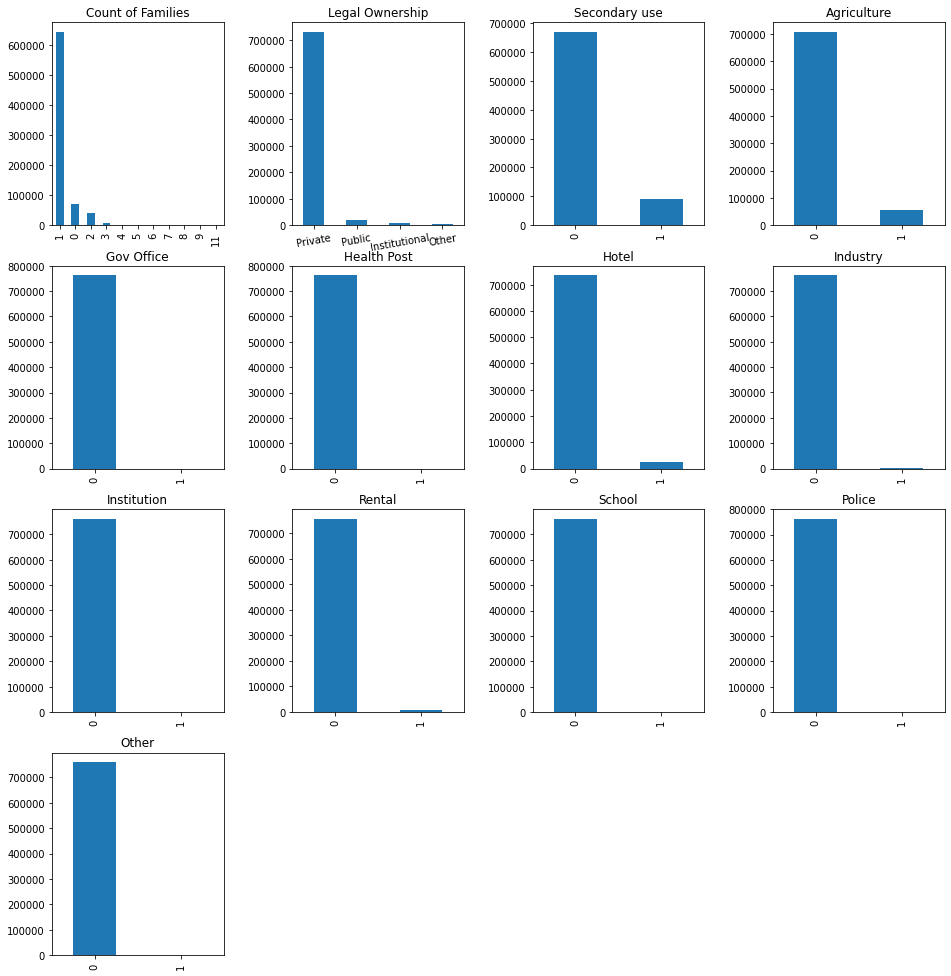

In [ ]:
plt.subplot(441)
ownership_df['count_families'].value_counts().plot(kind='bar', title='Count of Families', figsize=(16,12))

plt.subplot(442)
ownership_df['legal_ownership_status'].value_counts().plot(kind='bar', title='Legal Ownership',figsize=(16,12))
plt.xticks(rotation = 10 )

plt.subplot(443)
ownership_df['has_secondary_use'].value_counts().plot(kind='bar', title='Secondary use',figsize=(16,12))

plt.subplot(444)
ownership_df['has_secondary_use_agriculture'].value_counts().plot(kind='bar', title='Agriculture',figsize=(16,12))

plt.subplot(445)
ownership_df['has_secondary_use_gov_office'].value_counts().plot(kind='bar', title='Gov Office',figsize=(16,12))

plt.subplot(446)
ownership_df['has_secondary_use_health_post'].value_counts().plot(kind='bar', title='Health Post',figsize=(16,12))

plt.subplot(447)
ownership_df['has_secondary_use_hotel'].value_counts().plot(kind='bar', title='Hotel',figsize=(16,12))

plt.subplot(448)
ownership_df['has_secondary_use_industry'].value_counts().plot(kind='bar', title='Industry',figsize=(16,12))

plt.subplot(449)
ownership_df['has_secondary_use_institution'].value_counts().plot(kind='bar', title='Institution',figsize=(16,12))

plt.subplot(4,4,10)
ownership_df['has_secondary_use_rental'].value_counts().plot(kind='bar', title='Rental',figsize=(16,12))

plt.subplot(4,4,11)
ownership_df['has_secondary_use_school'].value_counts().plot(kind='bar', title='School',figsize=(16,12))

plt.subplot(4,4,12)
ownership_df['has_secondary_use_use_police'].value_counts().plot(kind='bar', title='Police',figsize=(16,12))

plt.subplot(4,4,13)
ownership_df['has_secondary_use_other'].value_counts().plot(kind='bar', title='Other',figsize=(16,12))

plt.subplots_adjust(bottom=-0.2,wspace=0.4)
plt.show()

**Findings from this visualisation :**


*   Majority of buildings have one family living in it.
*   Most of the building are privately owned
*   Buildings were majorly being used to serve their primary purpose most likely,they had families living in them.
*   Only few buildings had a secondary usage





Identifying the damage grade level faced by each legal owner

In [ ]:
damage_df = pd.read_csv('/content/csv_building_damage_assessment.csv')
ownership_grade_query = ''' select d.damage_grade,o.legal_ownership_status,o.has_secondary_use from ownership_df o join damage_df d on o.building_id = d.building_id '''
ownership_grade_df = ps.sqldf(ownership_grade_query,locals())
ownership_grade_df

,damage_grade,legal_ownership_status,has_secondary_use
0,Grade 3,Private,0
1,Grade 5,Private,0
2,Grade 2,Private,0
3,Grade 2,Private,0
4,Grade 1,Private,0
...,...,...,...
762088,Grade 5,Private,0
762089,Grade 5,Private,0
762090,Grade 5,Private,0
762091,Grade 5,Private,0


**Goal : To visualize how building owner by different owners have been affected**

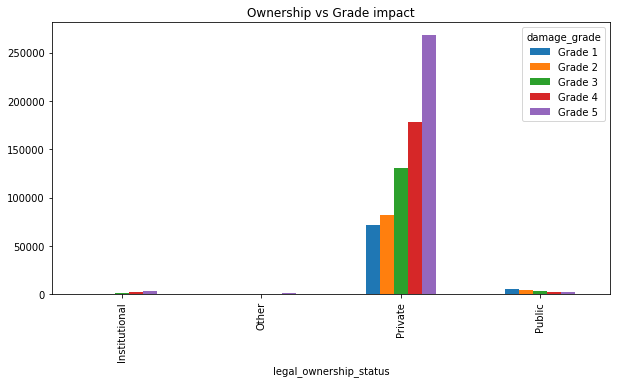

In [ ]:
d1 = ownership_grade_df.groupby(['legal_ownership_status','damage_grade']).size().unstack("damage_grade")
d1.plot(kind='bar',title="Ownership vs Grade impact",figsize=(10,5))
plt.show()

**Findings from this visualisation :**
Most of the buildings that were privately owned were effected by the earthquake.

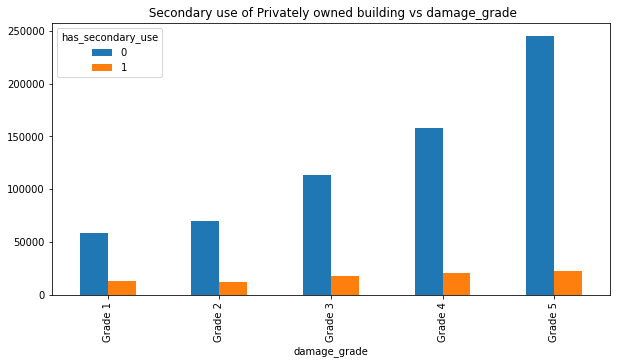

In [ ]:
d3 =ownership_grade_df.loc[(ownership_grade_df['legal_ownership_status']=="Private")].groupby(['damage_grade','has_secondary_use']).size().unstack("has_secondary_use")
d3.plot(kind='bar',title = " Secondary use of Privately owned building vs damage_grade",figsize=(10,5))
plt.show()

**Findings from this visualisation :** Privately owned buildings serving a secondary purpose were less effected.

**II. Cleaning and EDA for Building Damage Assessment Table**

**Columns in this table and some important metadata information** - 
1. Building ID - Each building has a unique ID 
2. District ID - Based on the location of the house of the individual
3. VDC MUN ID - In Nepal, districts are subdivided into localities known as Village Development Committees (VDCs)
4. Ward ID - Each VDC is further subdivided into wards and each ward has been allocated a unique number in this dataset. 
5. Damage overall collapse - categorical values representing the level of building collapse 
6. Damage overall leaning - categorical values representing the level of leaning 
7. Damage foundation - categorical values representing the level of damage of foundation
8. Damage roof - categorical values representing the level of damage of roof
9. Area assessed - categorical values representing the assessed area for technical solutions and repairs 
10. Damage Grade - The level of damage occured
11. Technical solution proposed - Solutions proposed for repairing
12. Geotechnical risk - Other risks which could be dangerous to the building's current condition


In [ ]:
damage_df = pd.read_csv('/content/csv_building_damage_assessment.csv')
damage_df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17,29,34,35,36,37,38,39,40,41,42,47,50) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,building_id,district_id,vdcmun_id,ward_id,damage_overall_collapse,damage_overall_leaning,damage_overall_adjacent_building_risk,damage_foundation_severe,damage_foundation_moderate,damage_foundation_insignificant,damage_roof_severe,damage_roof_moderate,damage_roof_insignificant,damage_corner_separation_severe,damage_corner_separation_moderate,damage_corner_separation_insignificant,damage_diagonal_cracking_severe,damage_diagonal_cracking_moderate,damage_diagonal_cracking_insignificant,damage_in_plane_failure_severe,damage_in_plane_failure_moderate,damage_in_plane_failure_insignificant,damage_out_of_plane_failure_severe,damage_out_of_plane_failure_moderate,damage_out_of_plane_failure_insignificant,damage_out_of_plane_failure_walls_ncfr_severe,damage_out_of_plane_failure_walls_ncfr_moderate,damage_out_of_plane_failure_walls_ncfr_insignificant,damage_gable_failure_severe,damage_gable_failure_moderate,damage_gable_failure_insignificant,damage_delamination_failure_severe,damage_delamination_failure_moderate,damage_delamination_failure_insignificant,damage_column_failure_severe,damage_column_failure_moderate,damage_column_failure_insignificant,damage_beam_failure_severe,damage_beam_failure_moderate,damage_beam_failure_insignificant,damage_infill_partition_failure_severe,damage_infill_partition_failure_moderate,damage_infill_partition_failure_insignificant,damage_staircase_severe,damage_staircase_moderate,damage_staircase_insignificant,damage_parapet_severe,damage_parapet_moderate,damage_parapet_insignificant,damage_cladding_glazing_severe,damage_cladding_glazing_moderate,damage_cladding_glazing_insignificant,area_assesed,damage_grade,technical_solution_proposed,has_repair_started,has_damage_foundation,has_damage_roof,has_damage_corner_separation,has_damage_diagonal_cracking,has_damage_in_plane_failure,has_damage_out_of_plane_failure,has_damage_out_of_plane_walls_ncfr_failure,has_damage_gable_failure,has_damage_delamination_failure,has_damage_column_failure,has_damage_beam_failure,has_damage_infill_partition_failure,has_damage_staircase,has_damage_parapet,has_damage_cladding_glazing,has_geotechnical_risk,has_geotechnical_risk_land_settlement,has_geotechnical_risk_fault_crack,has_geotechnical_risk_liquefaction,has_geotechnical_risk_landslide,has_geotechnical_risk_rock_fall,has_geotechnical_risk_flood,has_geotechnical_risk_other
0,120101000011,12,1207,120703,Moderate-Heavy,Insignificant/light,None,NaN,Moderate-Heavy-(<1/3),Insignificant/light-(<1/3),Severe-Extreme-(<1/3),NaN,Insignificant/light-(>2/3),Severe-Extreme-(>2/3),NaN,NaN,Severe-Extreme-(<1/3),NaN,NaN,Severe-Extreme-(>2/3),NaN,NaN,NaN,Moderate-Heavy-(>2/3),NaN,Severe-Extreme-(>2/3),NaN,NaN,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,Both,Grade 3,Major repair,0.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
1,120101000021,12,1207,120703,Severe-Extreme,Severe-Extreme,Insignificant/light,Severe-Extreme-(>2/3),NaN,NaN,Severe-Extreme-(>2/3),NaN,NaN,Severe-Extreme-(>2/3),NaN,NaN,Severe-Extreme-(>2/3),NaN,NaN,Severe-Extreme-(>2/3),NaN,NaN,Severe-Extreme-(>2/3),NaN,NaN,Severe-Extreme-(>2/3),NaN,NaN,None,NaN,NaN,Severe-Extreme-(>2/3),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,Exterior,Grade 5,Reconstruction,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
2,120101000031,12,1207,120703,Moderate-Heavy,Moderate-Heavy,Moderate-Heavy,NaN,Moderate-Heavy-(>2/3),NaN,NaN,Moderate-Heavy-(>2/3),NaN,NaN,Moderate-Heavy-(>2/3),NaN,NaN,Moderate-Heavy-(>2/3),NaN,NaN,Moderate-Heavy-(>2/3),NaN,NaN,Moderate-Heavy-(>2/3),NaN,NaN,Moderate-Heavy-(>2/3),NaN,NaN,Moderate-Heavy-(>2/3),NaN,NaN,NaN,Insignificant/light-(1/3-2/3),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,NaN,NaN,Both,Grade 2,Minor repair,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0
3,120101000041,12,1207,120703,Moderate-Heavy,Mod

In [ ]:
damage_df.shape

(762106, 79)

In [ ]:
damage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762106 entries, 0 to 762105
Data columns (total 79 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   building_id                                           762106 non-null  int64  
 1   district_id                                           762106 non-null  int64  
 2   vdcmun_id                                             762106 non-null  int64  
 3   ward_id                                               762106 non-null  int64  
 4   damage_overall_collapse                               500743 non-null  object 
 5   damage_overall_leaning                                500742 non-null  object 
 6   damage_overall_adjacent_building_risk                 500742 non-null  object 
 7   damage_foundation_severe                              254544 non-null  object 
 8   damage_foundation_moderate                  

The damage grade column has null values and also is an important column on which the complete meaning of this table depends. Therefore,removing the instances where there is null in this column.

In [ ]:
damage_df.dropna(subset=['damage_grade'],inplace=True)

Checking the values in each column and their respective counts.

In [ ]:
for col in damage_df.columns[4:]:
  print("Column name: ",col)
  print("value counts :\n",damage_df[col].value_counts().to_dict())
  print(" ")

Column name:  damage_overall_collapse
value counts :
 {'Moderate-Heavy': 205439, 'Severe-Extreme': 115878, 'Insignificant/light': 107614, 'None': 71809}
 
Column name:  damage_overall_leaning
value counts :
 {'None': 230124, 'Insignificant/light': 154133, 'Moderate-Heavy': 90306, 'Severe-Extreme': 26177}
 
Column name:  damage_overall_adjacent_building_risk
value counts :
 {'None': 395213, 'Insignificant/light': 53550, 'Moderate-Heavy': 31562, 'Severe-Extreme': 20415}
 
Column name:  damage_foundation_severe
value counts :
 {'None': 200912, 'Severe-Extreme-(>2/3)': 29189, 'Severe-Extreme-(<1/3)': 24442}
 
Column name:  damage_foundation_moderate
value counts :
 {'Moderate-Heavy-(>2/3)': 53243, 'Moderate-Heavy-(<1/3)': 50363}
 
Column name:  damage_foundation_insignificant
value counts :
 {'Insignificant/light-(<1/3)': 89373, 'Insignificant/light-(1/3-2/3)': 46162, 'Insignificant/light-(>2/3)': 39367}
 
Column name:  damage_roof_severe
value counts :
 {'None': 124279, 'Severe-Extreme-(>

There are total 79 columns in this table.There are some columns which contain redudant information. For example : column 'has_damage_foundation' has information in the form of 1 and 0 storing the result whether the building had damaged foundation or not post the earthquake. This same information can be captured by other columns like - damage_foundation_severe , damage_foundation_moderate,damage_foundation_insignificant. These columns also store information in the form of 1 and 0, storing the level of damage on foundation. If it was severe damage the column damage_foundation_severe will have 1 and rest will have 0. And if no damage was done,everything will have 0.
Therefore,removing such redundant columns.

In [ ]:
for col in damage_df.columns[56:]:
  damage_df.drop(columns=col,inplace=True)

There are categorical values in some columns showing the severity of damage.These can be mapped to numbers from 1-7,with 1 being less severe and 7 being the most severe.

In [ ]:
mappings = { "Severe-Extreme-(>2/3)": 7, 
             "Severe-Extreme-(<1/3)": 6,
             "Moderate-Heavy-(>2/3)": 5,
             "Moderate-Heavy-(<1/3)": 4,
             "Insignificant/light-(<1/3)":3, 
             "Insignificant/light-(1/3-2/3)":2, 
             "Insignificant/light-(>2/3)" : 1
            }
  
# combine this new data with existing DataFrame

for col in damage_df.columns[7:52]:
  damage_df[col] = damage_df[col].map(mappings)

There are categorical values in some columns showing the severity of damage.These can be mapped to numbers from 1-3,with 1 being less severe and 3 being the most severe.

In [ ]:
mappings = { "Severe-Extreme": 3, 
             "Moderate-Heavy": 2,
             "Insignificant/light":1
            }
  
# combine this new data with existing DataFrame

for col in damage_df.columns[4:7]:
  damage_df[col] = damage_df[col].map(mappings)

In [ ]:
damage_df

,building_id,district_id,vdcmun_id,ward_id,damage_overall_collapse,damage_overall_leaning,damage_overall_adjacent_building_risk,damage_foundation_severe,damage_foundation_moderate,damage_foundation_insignificant,damage_roof_severe,damage_roof_moderate,damage_roof_insignificant,damage_corner_separation_severe,damage_corner_separation_moderate,damage_corner_separation_insignificant,damage_diagonal_cracking_severe,damage_diagonal_cracking_moderate,damage_diagonal_cracking_insignificant,damage_in_plane_failure_severe,damage_in_plane_failure_moderate,damage_in_plane_failure_insignificant,damage_out_of_plane_failure_severe,damage_out_of_plane_failure_moderate,damage_out_of_plane_failure_insignificant,damage_out_of_plane_failure_walls_ncfr_severe,damage_out_of_plane_failure_walls_ncfr_moderate,damage_out_of_plane_failure_walls_ncfr_insignificant,damage_gable_failure_severe,damage_gable_failure_moderate,damage_gable_failure_insignificant,damage_delamination_failure_severe,damage_delamination_failure_moderate,damage_delamination_failure_insignificant,damage_column_failure_severe,damage_column_failure_moderate,damage_column_failure_insignificant,damage_beam_failure_severe,damage_beam_failure_moderate,damage_beam_failure_insignificant,damage_infill_partition_failure_severe,damage_infill_partition_failure_moderate,damage_infill_partition_failure_insignificant,damage_staircase_severe,damage_staircase_moderate,damage_staircase_insignificant,damage_parapet_severe,damage_parapet_moderate,damage_parapet_insignificant,damage_cladding_glazing_severe,damage_cladding_glazing_moderate,damage_cladding_glazing_insignificant,area_assesed,damage_grade,technical_solution_proposed,has_repair_started
0,120101000011,12,1207,120703,2.0,1.0,NaN,NaN,4.0,3.0,6.0,NaN,1.0,7.0,NaN,NaN,6.0,NaN,NaN,7.0,NaN,NaN,NaN,5.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Both,Grade 3,Major repair,0.0
1,120101000021,12,1207,120703,3.0,3.0,1.0,7.0,NaN,NaN,7.0,NaN,NaN,7.0,NaN,NaN,7.0,NaN,NaN,7.0,NaN,NaN,7.0,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Exterior,Grade 5,Reconstruction,1.0
2,120101000031,12,1207,120703,2.0,2.0,2.0,NaN,5.0,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Both,Grade 2,Minor repair,1.0
3,120101000041,12,1207,120703,2.0,2.0,2.0,NaN,5.0,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,NaN,3.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Both,Grade 2,Minor repair,1.0
4,120101000051,12,1207,120703,1.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,3.0,NaN,NaN,3.0,NaN,NaN,3.0,NaN,NaN,3.0,NaN,NaN,3.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Exterior,Grade 1,Minor repair,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762101,366709001241,36,3603,360302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Building removed,Grade 5,Reconstruction,0.0
762102,366709001251,36,3603,360302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Building removed,Grade 5,Reconstruction,0.0
762103,366709001261,36,3603,360302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Building removed,Grade 5,Reconst

In [ ]:
damage_df = damage_df.fillna(0)
damage_df = damage_df.replace('None',0)
damage_df

,building_id,district_id,vdcmun_id,ward_id,damage_overall_collapse,damage_overall_leaning,damage_overall_adjacent_building_risk,damage_foundation_severe,damage_foundation_moderate,damage_foundation_insignificant,damage_roof_severe,damage_roof_moderate,damage_roof_insignificant,damage_corner_separation_severe,damage_corner_separation_moderate,damage_corner_separation_insignificant,damage_diagonal_cracking_severe,damage_diagonal_cracking_moderate,damage_diagonal_cracking_insignificant,damage_in_plane_failure_severe,damage_in_plane_failure_moderate,damage_in_plane_failure_insignificant,damage_out_of_plane_failure_severe,damage_out_of_plane_failure_moderate,damage_out_of_plane_failure_insignificant,damage_out_of_plane_failure_walls_ncfr_severe,damage_out_of_plane_failure_walls_ncfr_moderate,damage_out_of_plane_failure_walls_ncfr_insignificant,damage_gable_failure_severe,damage_gable_failure_moderate,damage_gable_failure_insignificant,damage_delamination_failure_severe,damage_delamination_failure_moderate,damage_delamination_failure_insignificant,damage_column_failure_severe,damage_column_failure_moderate,damage_column_failure_insignificant,damage_beam_failure_severe,damage_beam_failure_moderate,damage_beam_failure_insignificant,damage_infill_partition_failure_severe,damage_infill_partition_failure_moderate,damage_infill_partition_failure_insignificant,damage_staircase_severe,damage_staircase_moderate,damage_staircase_insignificant,damage_parapet_severe,damage_parapet_moderate,damage_parapet_insignificant,damage_cladding_glazing_severe,damage_cladding_glazing_moderate,damage_cladding_glazing_insignificant,area_assesed,damage_grade,technical_solution_proposed,has_repair_started
0,120101000011,12,1207,120703,2.0,1.0,0.0,0.0,4.0,3.0,6.0,0.0,1.0,7.0,0.0,0.0,6.0,0.0,0.0,7.0,0.0,0.0,0.0,5.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Both,Grade 3,Major repair,0.0
1,120101000021,12,1207,120703,3.0,3.0,1.0,7.0,0.0,0.0,7.0,0.0,0.0,7.0,0.0,0.0,7.0,0.0,0.0,7.0,0.0,0.0,7.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Exterior,Grade 5,Reconstruction,1.0
2,120101000031,12,1207,120703,2.0,2.0,2.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Both,Grade 2,Minor repair,1.0
3,120101000041,12,1207,120703,2.0,2.0,2.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Both,Grade 2,Minor repair,1.0
4,120101000051,12,1207,120703,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Exterior,Grade 1,Minor repair,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762101,366709001241,36,3603,360302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Building removed,Grade 5,Reconstruction,0.0
762102,366709001251,36,3603,360302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Building removed,Grade 5,Reconstruction,0.0
762103,366709001261,36,3603,360302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Building removed,Grade 5,Reconst

After categorically mapping columns above, we can calculate net severity of an attribute. Here,we have considered the highest level of severity as the value and removed all others.

In [ ]:
damage_df['damage_foundation']=damage_df[['damage_foundation_severe','damage_foundation_moderate','damage_foundation_insignificant']].max(axis=1)
damage_df.drop(columns=['damage_foundation_severe','damage_foundation_moderate','damage_foundation_insignificant'],inplace=True)

damage_df['damage_roof']=damage_df[['damage_roof_severe','damage_roof_moderate','damage_roof_insignificant']].max(axis=1)
damage_df.drop(columns=['damage_roof_severe','damage_roof_moderate','damage_roof_insignificant'],inplace=True)

damage_df['damage_corner_separation']=damage_df[['damage_corner_separation_severe','damage_corner_separation_moderate','damage_corner_separation_insignificant']].max(axis=1)
damage_df.drop(columns=['damage_corner_separation_severe','damage_corner_separation_moderate','damage_corner_separation_insignificant'],inplace=True)

damage_df['damage_diagonal_cracking']=damage_df[['damage_diagonal_cracking_severe','damage_diagonal_cracking_moderate','damage_diagonal_cracking_insignificant']].max(axis=1)
damage_df.drop(columns=['damage_diagonal_cracking_severe','damage_diagonal_cracking_moderate','damage_diagonal_cracking_insignificant'],inplace=True)

damage_df['damage_in_plane_failure']=damage_df[['damage_in_plane_failure_severe','damage_in_plane_failure_moderate','damage_in_plane_failure_insignificant']].max(axis=1)
damage_df.drop(columns=['damage_in_plane_failure_severe','damage_in_plane_failure_moderate','damage_in_plane_failure_insignificant'],inplace=True)

damage_df['damage_out_of_plane_failure']=damage_df[['damage_out_of_plane_failure_severe','damage_out_of_plane_failure_moderate','damage_out_of_plane_failure_insignificant']].max(axis=1)
damage_df.drop(columns=['damage_out_of_plane_failure_severe','damage_out_of_plane_failure_moderate','damage_out_of_plane_failure_insignificant'],inplace=True)

damage_df['damage_out_of_plane_failure_walls_ncfr']=damage_df[['damage_out_of_plane_failure_walls_ncfr_severe','damage_out_of_plane_failure_walls_ncfr_moderate','damage_out_of_plane_failure_walls_ncfr_insignificant']].max(axis=1)
damage_df.drop(columns=['damage_out_of_plane_failure_walls_ncfr_severe','damage_out_of_plane_failure_walls_ncfr_moderate','damage_out_of_plane_failure_walls_ncfr_insignificant'],inplace=True)

damage_df['damage_gable_failure']=damage_df[['damage_gable_failure_severe','damage_gable_failure_moderate','damage_gable_failure_insignificant']].max(axis=1)
damage_df.drop(columns=['damage_gable_failure_severe','damage_gable_failure_moderate','damage_gable_failure_insignificant'],inplace=True)

damage_df['damage_delamination_failure']=damage_df[['damage_delamination_failure_severe','damage_delamination_failure_moderate','damage_delamination_failure_insignificant']].max(axis=1)
damage_df.drop(columns=['damage_delamination_failure_severe','damage_delamination_failure_moderate','damage_delamination_failure_insignificant'],inplace=True)

damage_df['damage_column_failure']=damage_df[['damage_column_failure_severe','damage_column_failure_moderate','damage_column_failure_insignificant']].max(axis=1)
damage_df.drop(columns=['damage_column_failure_severe','damage_column_failure_moderate','damage_column_failure_insignificant'],inplace=True)

damage_df['damage_beam_failure']=damage_df[['damage_beam_failure_severe','damage_beam_failure_moderate','damage_beam_failure_insignificant']].max(axis=1)
damage_df.drop(columns=['damage_beam_failure_severe','damage_beam_failure_moderate','damage_beam_failure_insignificant'],inplace=True)

damage_df['damage_infill_partition_failure']=damage_df[['damage_infill_partition_failure_severe','damage_infill_partition_failure_moderate','damage_infill_partition_failure_insignificant']].max(axis=1)
damage_df.drop(columns=['damage_infill_partition_failure_severe','damage_infill_partition_failure_moderate','damage_infill_partition_failure_insignificant'],inplace=True)

damage_df['damage_staircase']=damage_df[['damage_staircase_severe','damage_staircase_moderate','damage_staircase_insignificant']].max(axis=1)
damage_df.drop(columns=['damage_staircase_severe','damage_staircase_moderate','damage_staircase_insignificant'],inplace=True)

damage_df['damage_parapet']=damage_df[['damage_parapet_severe','damage_parapet_moderate','damage_parapet_insignificant']].max(axis=1)
damage_df.drop(columns=['damage_parapet_severe','damage_parapet_moderate','damage_parapet_insignificant'],inplace=True)

damage_df['damage_cladding_glazing']=damage_df[['damage_cladding_glazing_severe','damage_cladding_glazing_moderate','damage_cladding_glazing_insignificant']].max(axis=1)
damage_df.drop(columns=['damage_cladding_glazing_severe','damage_cladding_glazing_moderate','damage_cladding_glazing_insignificant'],inplace=True)

In [ ]:
#Final dataset shape
damage_df.shape

(762094, 26)

In [ ]:
#Final dataframe
damage_df

,building_id,district_id,vdcmun_id,ward_id,damage_overall_collapse,damage_overall_leaning,damage_overall_adjacent_building_risk,area_assesed,damage_grade,technical_solution_proposed,has_repair_started,damage_foundation,damage_roof,damage_corner_separation,damage_diagonal_cracking,damage_in_plane_failure,damage_out_of_plane_failure,damage_out_of_plane_failure_walls_ncfr,damage_gable_failure,damage_delamination_failure,damage_column_failure,damage_beam_failure,damage_infill_partition_failure,damage_staircase,damage_parapet,damage_cladding_glazing
0,120101000011,12,1207,120703,2.0,1.0,0.0,Both,Grade 3,Major repair,0.0,4.0,6.0,7.0,6.0,7.0,5.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,120101000021,12,1207,120703,3.0,3.0,1.0,Exterior,Grade 5,Reconstruction,1.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
2,120101000031,12,1207,120703,2.0,2.0,2.0,Both,Grade 2,Minor repair,1.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,120101000041,12,1207,120703,2.0,2.0,2.0,Both,Grade 2,Minor repair,1.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,3.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0
4,120101000051,12,1207,120703,1.0,0.0,0.0,Exterior,Grade 1,Minor repair,1.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762101,366709001241,36,3603,360302,0.0,0.0,0.0,Building removed,Grade 5,Reconstruction,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
762102,366709001251,36,3603,360302,0.0,0.0,0.0,Building removed,Grade 5,Reconstruction,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
762103,366709001261,36,3603,360302,0.0,0.0,0.0,Building removed,Grade 5,Reconstruction,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
762104,366709001271,36,3603,360302,0.0,0.0,0.0,Building removed,Grade 5,Reconstruction,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Goal : To see the correlation between the damage grade and damage of foundation,roof and technical solutions proposed**

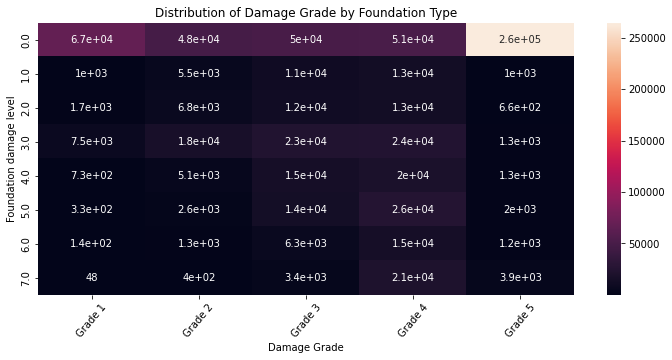

In [ ]:
df1 = damage_df[['damage_grade','damage_foundation']]
df_temp = df1.groupby(['damage_foundation','damage_grade']).size().reset_index(name='count')

# Set Index
df_temp = df_temp.set_index(['damage_grade','damage_foundation'])

# Pivot table
df_temp = pd.pivot_table(df_temp, values='count', index=['damage_foundation'], columns='damage_grade')
# Plot char
plt.figure(figsize=(12,5))
ax = sns.heatmap(data = df_temp, annot = True )
plt.xticks(rotation = 50)
plt.title("Distribution of Damage Grade by Foundation Type")
plt.xlabel("Damage Grade")
plt.ylabel("Foundation damage level")
plt.show()

**Findings from this visualisation :** We can see that there is a significant correlation between the damage grade and the damage to foundation. There is a high number of severly damaged foundation by damage of Grade 5.

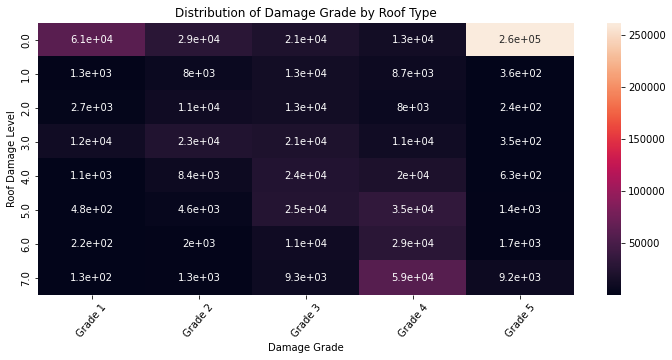

In [ ]:
df1 = damage_df[['damage_grade','damage_roof']]
df_temp = df1.groupby(['damage_roof','damage_grade']).size().reset_index(name='count')

# Set Index
df_temp = df_temp.set_index(['damage_grade','damage_roof'])

# Pivot table
df_temp = pd.pivot_table(df_temp, values='count', index=['damage_roof'], columns='damage_grade')
# Plot char
plt.figure(figsize=(12,5))
ax = sns.heatmap(data = df_temp, annot = True )
plt.xticks(rotation = 50)
plt.title("Distribution of Damage Grade by Roof Type")
plt.xlabel("Damage Grade")
plt.ylabel("Roof Damage Level")
plt.show()

**Findings from this visualisation :** We can see that there is a significant correlation between the damage grade and the damage to roof. There is a high number of severly damaged roofs by damage of Grade 5.

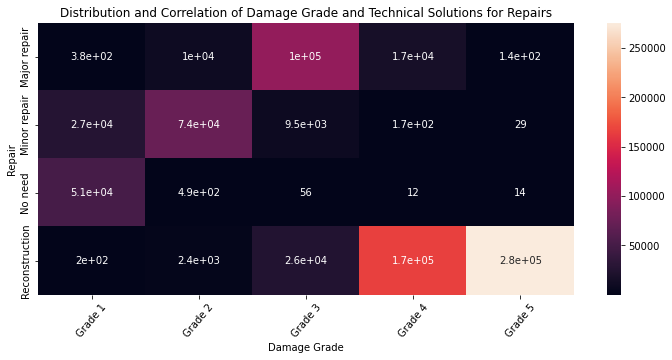

In [ ]:
df2 = damage_df[['damage_grade','technical_solution_proposed']]
df_temp = df2.groupby(['technical_solution_proposed','damage_grade']).size().reset_index(name='count')
df_temp = df_temp.set_index(['technical_solution_proposed', 'damage_grade']).reset_index()
df_temp = pd.pivot_table(df_temp, values='count', index=['technical_solution_proposed'], columns='damage_grade')
plt.figure(figsize=(12,5))
ax = sns.heatmap(data = df_temp, annot = True )
plt.xticks(rotation = 50)
plt.title("Distribution and Correlation of Damage Grade and Technical Solutions for Repairs")
plt.xlabel("Damage Grade")
plt.ylabel("Repair")
plt.show()


**Findings from this visualisation :** We can see that there is a correlation between the damage grade and technical repiars.
Grade 5 damage caused maximum building to be reconstructed followed by Grade 4 whereas, minor repairs were needed for Grade 1 damage.

Identifying the damage impact by each district

In [ ]:
district_df = pd.read_csv('/content/ward_vdcmun_district_name_mapping.csv')

district_grade_query = '''select d1.district_name,d2.damage_grade from district_df d1 join damage_df d2 on d1.district_id = d2.district_id where d1.ward_id = d2.ward_id and d1.vdcmun_id = d2.vdcmun_id'''
district_grade_df = ps.sqldf(district_grade_query,locals())
district_grade_df = district_grade_df.groupby(['district_name','damage_grade']).size().unstack('damage_grade')

In [ ]:
district_grade_df

damage_grade,Grade 1,Grade 2,Grade 3,Grade 4,Grade 5
district_name,,,,,
Dhading,4952,7526,15218,26080,35346
Dolakha,1353,2993,6520,14409,35364
Gorkha,4351,8555,15507,22536,27125
Kavrepalanchok,8330,11726,25130,28974,23859
Makwanpur,32540,21135,18525,10928,7866
Nuwakot,2615,2745,8209,23284,40295
Okhaldhunga,7961,8605,9220,7946,5620
Ramechhap,2116,7151,16945,20910,11490
Rasuwa,277,343,782,2064,9178


**Goal : To visualize which districts in Nepal were affected and by how much grade**

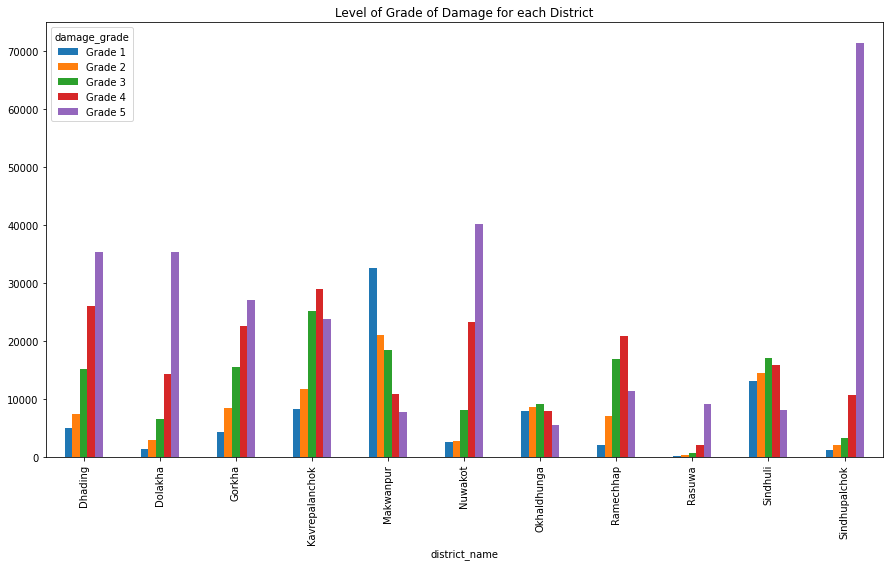

In [ ]:
district_grade_df.plot(kind='bar',title = "Level of Grade of Damage for each District",figsize=(15,8))
plt.show()

**Findings from this visualisation**: It can be observed Sindhupalchok district was the first affected. It had the highest no. of Grade 5 damages. Rasuwa district was less affected having comparitively less number of damages.

Identifying the type of repairs and reconstruction aids required at district level

In [ ]:
district_solution_query = '''select d1.district_name,d2.technical_solution_proposed from district_df d1 join damage_df d2 on d1.district_id = d2.district_id where d1.ward_id = d2.ward_id and d1.vdcmun_id = d2.vdcmun_id'''
district_solution_df = ps.sqldf(district_solution_query,locals())
district_solution_df = district_solution_df.groupby(['district_name','technical_solution_proposed']).size().unstack('technical_solution_proposed')

In [ ]:
district_solution_df

technical_solution_proposed,Major repair,Minor repair,No need,Reconstruction
district_name,,,,
Dhading,14684,9049,3362,62027
Dolakha,6660,3693,829,49457
Gorkha,14703,9417,2498,51456
Kavrepalanchok,22306,12997,5641,57075
Makwanpur,19815,32629,20769,17781
Nuwakot,8228,3784,1539,63597
Okhaldhunga,9048,10445,5261,14598
Ramechhap,13748,7978,1007,35879
Rasuwa,903,487,129,11125


**Goal : To visualize what types of repairs are required in each district of Nepal**

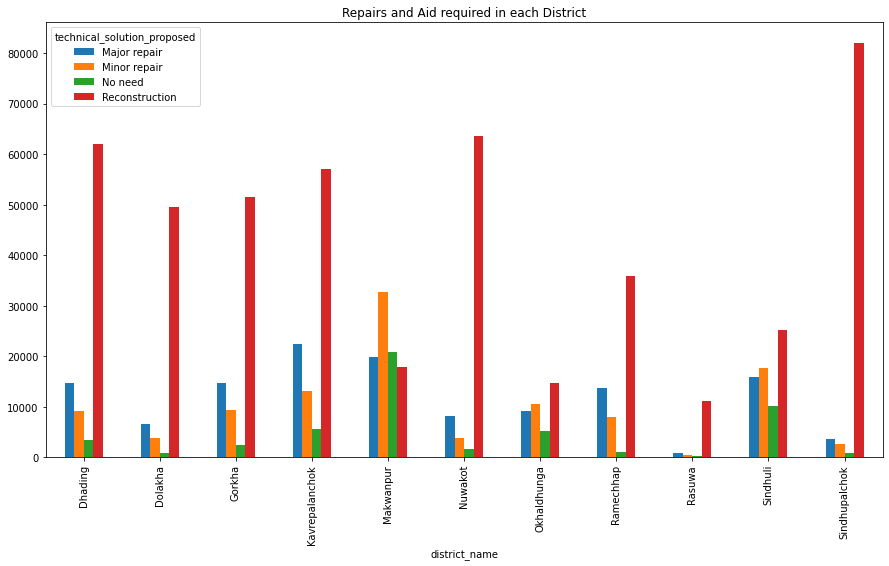

In [ ]:
district_solution_df.plot(kind='bar',title= "Repairs and Aid required in each District", figsize=(15,8))
plt.show()

**Findings from this visualisation** : It is observed since district Sindhupalchok was worst affected, it required more reconstruction level of repairs. Moreover, other districts as well required reconstruction to be done in vast numbers

**III. Cleaning and EDA for Building Structure Table**

**Columns in this table and some important metadata information -** 
1. Building ID - Each building has a unique ID 
2. District ID - Based on the location of the house of the individual
3. VDC MUN ID - In Nepal, districts are subdivided into localities known as Village Development Committees (VDCs)
4. Ward ID - Each VDC is further subdivided into wards and each ward has been allocated a unique number in this dataset. 
5. Damage overall collapse - categorical values representing the level of building collapse 
6. Damage overall leaning - categorical values representing the level of leaning 
7. Damage foundation - categorical values representing the level of damage of foundation
8. Damage roof - categorical values representing the level of damage of roof
9. Area assessed - categorical values representing the assessed area for technical solutions and repairs 
10. Damage Grade - The level of damage occured
11. Technical solution proposed - Solutions proposed for repairing
12. Geotechnical risk - Other risks which could be dangerous to the building's current condition


In [ ]:
structure_df = pd.read_csv('/content/csv_building_structure.csv')
structure_df

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,condition_post_eq,damage_grade,technical_solution_proposed
0,120101000011,12,1207,120703,1,1,9,288,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0,1,0,0,0,0,0,1,0,0,0,Damaged-Used in risk,Grade 3,Major repair
1,120101000021,12,1207,120703,1,1,15,364,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0,1,0,0,0,0,0,1,0,0,0,Damaged-Repaired and used,Grade 5,Reconstruction
2,120101000031,12,1207,120703,1,1,20,384,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 2,Minor repair
3,120101000041,12,1207,120703,1,1,20,312,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 2,Minor repair
4,120101000051,12,1207,120703,1,1,30,308,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 1,Minor repair
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762101,366709001241,36,3603,360302,2,0,60,165,18,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,Timber-Planck,Attached-2 side,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Rubble clear,Grade 5,Reconstruction
762102,366709001251,36,3603,360302,2,0,35,342,18,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,Timber-Planck,Attached-1 side,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Rubble clear,Grade 5,Reconstruction
762103,366709001261,36,3603,360302,2,0,35,342,18,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,Timber-Planck,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Rubble clear,Grade 5,Reconstruction
762104,366709001271,36,3603,360302,2,0,19,306,18,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,Timber-Planck,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Rubble clear,Grade 5,Reconstruction


In [ ]:
structure_df.shape

(762106, 31)

In [ ]:
structure_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762106 entries, 0 to 762105
Data columns (total 31 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             762106 non-null  int64 
 1   district_id                             762106 non-null  int64 
 2   vdcmun_id                               762106 non-null  int64 
 3   ward_id                                 762106 non-null  int64 
 4   count_floors_pre_eq                     762106 non-null  int64 
 5   count_floors_post_eq                    762106 non-null  int64 
 6   age_building                            762106 non-null  int64 
 7   plinth_area_sq_ft                       762106 non-null  int64 
 8   height_ft_pre_eq                        762106 non-null  int64 
 9   height_ft_post_eq                       762106 non-null  int64 
 10  land_surface_condition                  762106 non-null 

In [ ]:
structure_df.dropna(inplace=True)

Checking the values in each column and their respective counts.

In [ ]:
for col in structure_df.columns[4:]:
  print("column name: ",col)
  print(structure_df[col].value_counts().to_dict())
  print(" ")

column name:  count_floors_pre_eq
{2: 468103, 3: 166993, 1: 118899, 4: 6085, 5: 1569, 6: 332, 7: 88, 9: 13, 8: 12}
 
column name:  count_floors_post_eq
{2: 293381, 0: 261353, 1: 132023, 3: 68547, 4: 4839, 5: 1497, 6: 323, 7: 92, 8: 20, 9: 19}
 
column name:  age_building
{15: 49983, 20: 46525, 10: 39794, 25: 37063, 12: 36458, 30: 30826, 5: 29170, 3: 24430, 4: 23403, 7: 23382, 8: 22837, 22: 22612, 2: 21643, 6: 20113, 40: 19666, 18: 19643, 1: 19385, 14: 17402, 35: 16869, 16: 16527, 13: 15765, 9: 15151, 50: 14750, 17: 14157, 11: 11515, 27: 9961, 32: 9430, 26: 8834, 21: 8204, 24: 7943, 28: 7669, 19: 7341, 45: 7336, 60: 7178, 23: 6943, 0: 4732, 80: 4261, 70: 3999, 36: 3985, 42: 3675, 999: 3144, 55: 3031, 37: 3012, 29: 2929, 31: 2835, 33: 2629, 34: 2551, 38: 2429, 100: 1841, 65: 1812, 44: 1558, 52: 1555, 48: 1509, 90: 1460, 41: 1092, 46: 1092, 39: 1069, 47: 1061, 43: 1060, 85: 916, 54: 901, 75: 843, 82: 819, 51: 653, 57: 631, 56: 629, 62: 608, 58: 575, 53: 497, 49: 495, 99: 482, 61: 422, 72:

**Goal : To see which types of foundation in the building structure was vulenrable to the earthquake**

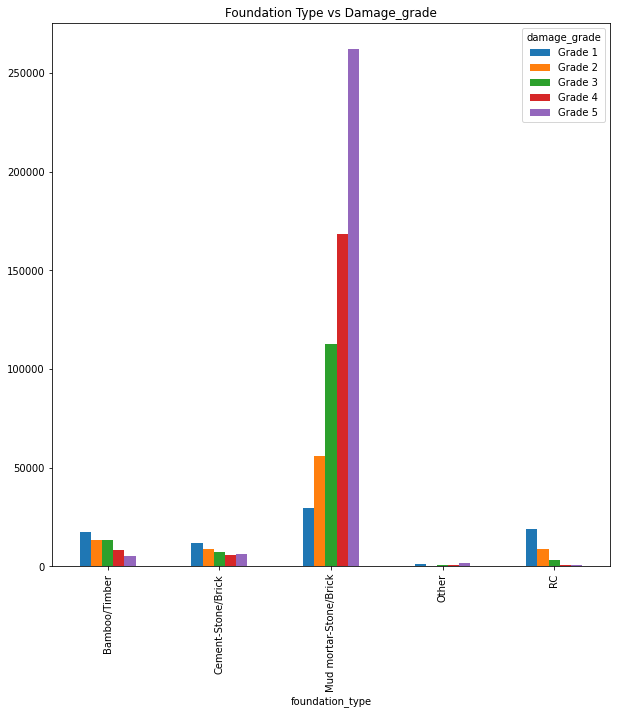

In [ ]:
s1 = structure_df.groupby(['foundation_type',"damage_grade"]).size().unstack("damage_grade")
s1.plot(kind='bar',title='Foundation Type vs Damage_grade', figsize=(10,10))
plt.show()

**Findings from this visualisation** : It can be observed that builidings having foundation made up of mud mortar or stone got affected more than RC engineered foundations.

**Goal : To visualise the role played by the age of building in handle the damage caused by earthquake**

Checking outliers for building age

<function matplotlib.pyplot.plot>

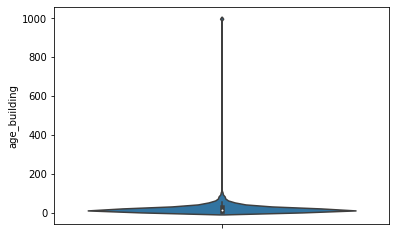

In [ ]:
sns.violinplot(y = structure_df['age_building'])
plt.plot

**Findings from this visualisation :** For major number of buildings,the age is ranging from 0- 200 years but there are buildings having age of more than 200 years all the ways upto 900 years

Visualising the damage grade level with buidling having age > 100

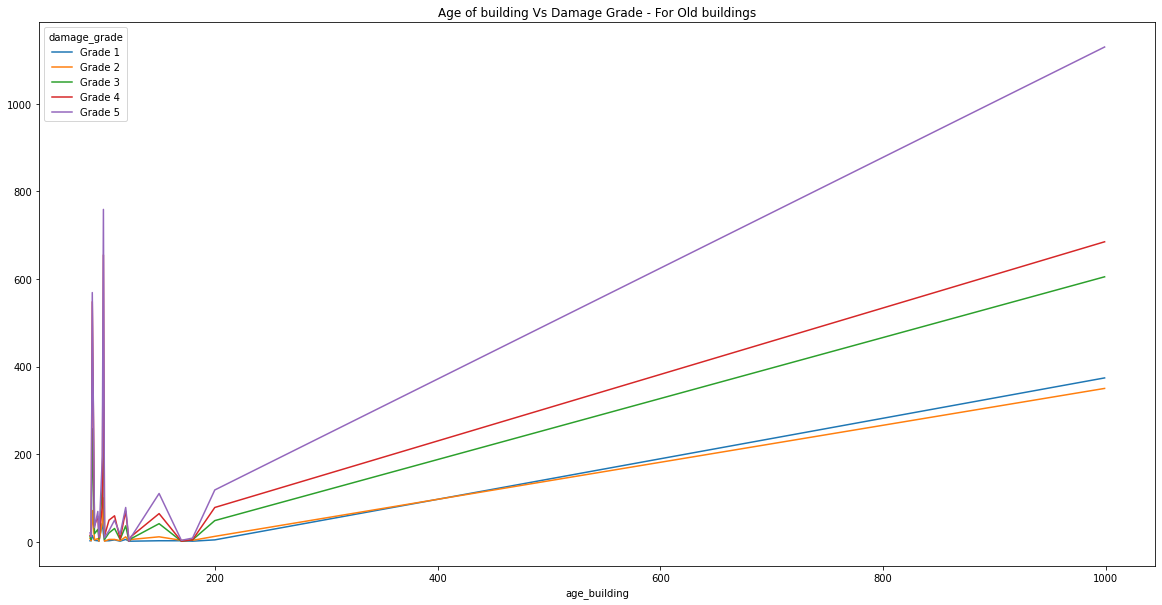

In [ ]:
s2 = structure_df.groupby(['age_building',"damage_grade"]).size().unstack("damage_grade").dropna().tail(20)
s2.plot(title='Age of building Vs Damage Grade - For Old buildings', figsize=(20,10))
plt.show()

**Findings from this visualisation :** We can see that as the age of building increase the damage increases

Visualising the damage grade level with buidling having age < 30

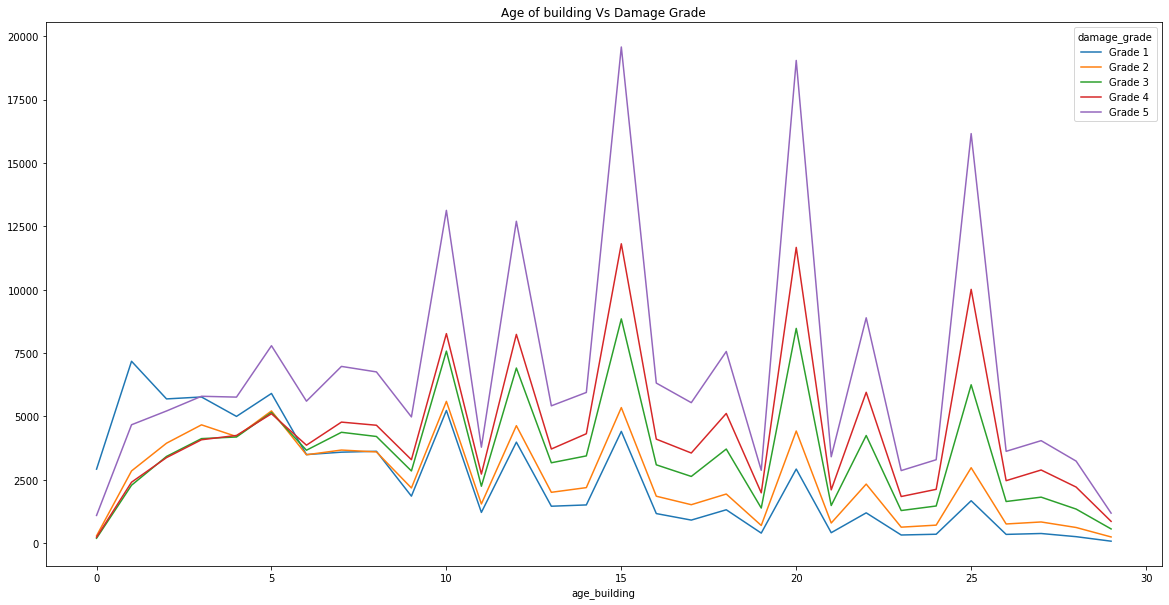

In [ ]:
s3 = structure_df.groupby(['age_building',"damage_grade"]).size().unstack("damage_grade").dropna().head(30)
s3.plot(title='Age of building Vs Damage Grade', figsize=(20,10))
plt.show()

**Findings from this visualisation :** For building having age under 30 years, the damage of impact is variable which indicates that there were other factors that lead to their destructuion apart from their age.

Visualizing the building structure attributes of building having age < 50 and with Damage Grade 5

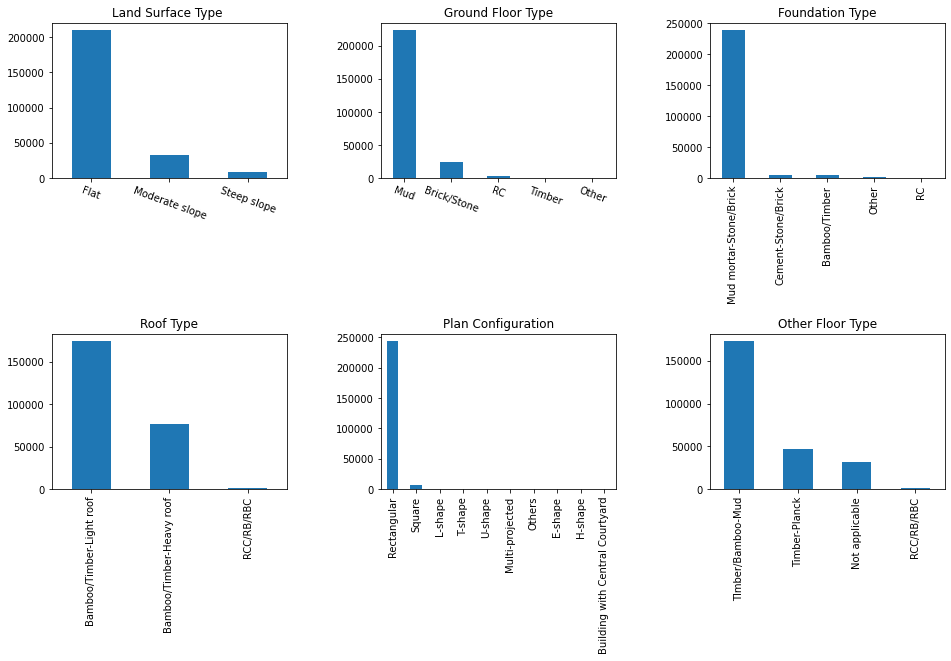

In [ ]:
s4 = structure_df[(structure_df['age_building']<50) & (structure_df['damage_grade'] == "Grade 5")]

plt.subplot(331)
s4['land_surface_condition'].value_counts().plot(kind='bar',title = "Land Surface Type ",figsize=(10,10))
plt.xticks(rotation = -20)

plt.subplot(332)
s4['ground_floor_type'].value_counts().plot(kind='bar',title = "Ground Floor Type",figsize=(16,10))
plt.xticks(rotation = -20)

plt.subplot(333)
s4['foundation_type'].value_counts().plot(kind='bar',title = "Foundation Type",figsize=(16,10))

plt.subplot(334)
s4['roof_type'].value_counts().plot(kind='bar',title = "Roof Type",figsize=(16,10))

plt.subplot(335)
s4['plan_configuration'].value_counts().plot(kind='bar',title = "Plan Configuration",figsize=(16,10))

plt.subplot(336)
s4['other_floor_type'].value_counts().plot(kind='bar',title = "Other Floor Type" , figsize=(16,10))


plt.subplots_adjust(bottom=-0.2,wspace=0.4,hspace=1)
plt.show()

**Findings from this visualisation :** Through these subplots,we can see that the building who has age less than 30 years and got damaged majorly had their groud floor type made up of mud,has weak foundations and roof types

#### Feature Engineering

Creating Features and Labels dataframe for modelling.
Since we will be predicting the damage grade,we will exclude it from our training set

In [ ]:
features = structure_df.drop(columns=['damage_grade'])
label = structure_df['damage_grade']

Creating a pipeline to apply transformations on columns.

In categorical_col and numerical_col we have stored the columns on which we do not want to apply any transformation.

In categorical_col having columns with categorical values and numerial_col having numerical values, we have selected columns to apply transformations on.

Futher,we have created two pipelines:
- num_pipeline =: Applying standard scaling on numerical columns
- cat_pipeline =: To one hot enconde all the categorical columns

In [ ]:
categorical_col = ['condition_post_eq','technical_solution_proposed']
numerical_col = ['district_id', 'vdcmun_id', 'ward_id','building_id','has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone','has_superstructure_stone_flag','has_superstructure_cement_mortar_stone',
                  'has_superstructure_mud_mortar_brick','has_superstructure_cement_mortar_brick', 'has_superstructure_timber','has_superstructure_bamboo', 'has_superstructure_rc_non_engineered','has_superstructure_rc_engineered', 'has_superstructure_other']

categorical_transform = structure_df.drop(categorical_col, axis = 1).select_dtypes(include=['object']).drop('damage_grade', axis = 1).columns
numerical_transform = structure_df.drop(numerical_col, axis = 1).select_dtypes(np.number).columns

# Numerical columns pipeline
num_pipeline = Pipeline(
    [("std_scaler", StandardScaler())])

cat_pipeline = Pipeline( [('onehot', OneHotEncoder(handle_unknown='ignore'))])

# full pipeline
full_pipeline = ColumnTransformer(
    [("numerical", num_pipeline, numerical_transform),('categorical', cat_pipeline, categorical_transform)])

Fitting the Pipeline to our features.

In [ ]:
features1 = full_pipeline.fit_transform(features)

Creating new column names for our new features

In [ ]:
onehotenc_categories = full_pipeline.named_transformers_["categorical"]["onehot"].categories_
new_categorical_features = [
    f"{col}__{value}" for col, vals in zip(categorical_transform,onehotenc_categories) for value in vals
]
new_features = numerical_transform.tolist() + new_categorical_features

Final features dataframe

In [ ]:
features1 = pd.DataFrame(features1, columns= new_features)
features1

,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition__Flat,land_surface_condition__Moderate slope,land_surface_condition__Steep slope,foundation_type__Bamboo/Timber,foundation_type__Cement-Stone/Brick,foundation_type__Mud mortar-Stone/Brick,foundation_type__Other,foundation_type__RC,roof_type__Bamboo/Timber-Heavy roof,roof_type__Bamboo/Timber-Light roof,roof_type__RCC/RB/RBC,ground_floor_type__Brick/Stone,ground_floor_type__Mud,ground_floor_type__Other,ground_floor_type__RC,ground_floor_type__Timber,other_floor_type__Not applicable,other_floor_type__RCC/RB/RBC,other_floor_type__TImber/Bamboo-Mud,other_floor_type__Timber-Planck,position__Attached-1 side,position__Attached-2 side,position__Attached-3 side,position__Not attached,plan_configuration__Building with Central Courtyard,plan_configuration__E-shape,plan_configuration__H-shape,plan_configuration__L-shape,plan_configuration__Multi-projected,plan_configuration__Others,plan_configuration__Rectangular,plan_configuration__Square,plan_configuration__T-shape,plan_configuration__U-shape
0,-1.660481,-0.237050,-0.235645,-0.523298,-1.283137,-0.101325,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-1.660481,-0.237050,-0.143386,-0.188172,-1.283137,-0.101325,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-1.660481,-0.237050,-0.066504,-0.099981,-1.283137,-0.101325,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-1.660481,-0.237050,-0.066504,-0.417469,-1.283137,-0.101325,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-1.660481,-0.237050,0.087261,-0.435107,-1.283137,-0.101325,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762089,-0.134005,-1.177538,0.548554,-1.065673,0.355044,-1.150984,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
762090,-0.134005,-1.177538,0.164143,-0.285182,0.355044,-1.150984,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
762091,-0.134005,-1.177538,0.164143,-0.285182,0.355044,-1.150984,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
762092,-0.134005,-1.177538,-0.081880,-0.443926,0.355044,-1.150984,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Splitting the data into testing and training

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features1,label,test_size = 0.2,random_state = 42, shuffle=True)

Since,our data had a lot of categorical values which have been one hot encoded,resulting in additional columns. This might increase no. of features which may not be necessary.Therefore,applying Principal component analysis on our training dataset.

Text(0, 0.5, 'explained variance')

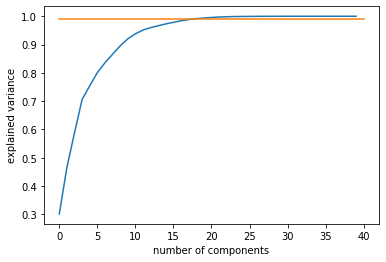

In [ ]:
pca = PCA(n_components=40)

pca.fit_transform(x_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.plot(np.arange(0, 41), [0.99]*41)
plt.xlabel('number of components')
plt.ylabel('explained variance')

We get highest explained variance ratio at around 20 components,therefore considering 20 components and transforming the training data on them.

In [ ]:
pca = PCA(n_components=20)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca =  pca.transform(x_test)

### Classification & Modeling

We will be using three types of classifiers for classifying the damage grade. They are as follows:

**I. Decision Tree Classifier**

In [ ]:
model = DecisionTreeClassifier(random_state=0)
model.fit(x_train_pca,y_train)

predictions_train = model.predict(x_train_pca)
train_accuracy = accuracy_score(y_train,predictions_train)
print("Training Accuracy",train_accuracy)

predictions_test = model.predict(x_test_pca)
test_accuracy = accuracy_score(y_test,predictions_test)
print("Testing Accuracy",test_accuracy)

Training Accuracy 0.9445294624185017
Testing Accuracy 0.5965463623301557


Confusion Matrix and Classification Report

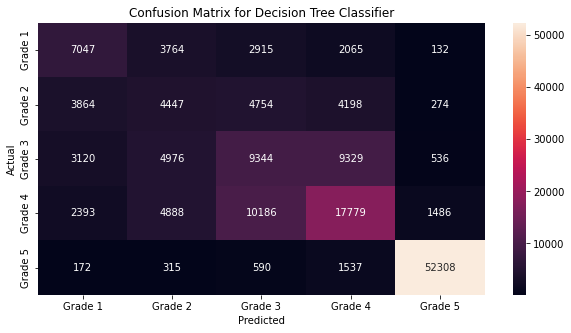

In [ ]:
conf_mat = pd.DataFrame(confusion_matrix(y_test,predictions_test), columns=np.unique(y_test), index = np.unique(y_test))
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'

plt.figure(figsize=(10,5))

sns.heatmap(conf_mat, annot=True, fmt='d')
plt.title("Confusion Matrix for Decision Tree Classifier")
plt.show()

In [ ]:
print("Classification Report Decision Tree")
print(classification_report(y_test, predictions_test))

Classification Report Decision Tree
              precision    recall  f1-score   support

     Grade 1       0.42      0.44      0.43     15923
     Grade 2       0.24      0.25      0.25     17537
     Grade 3       0.34      0.34      0.34     27305
     Grade 4       0.51      0.48      0.50     36732
     Grade 5       0.96      0.95      0.95     54922

    accuracy                           0.60    152419
   macro avg       0.49      0.49      0.49    152419
weighted avg       0.60      0.60      0.60    152419



**II. Multilayer Perceptron Classifier**

In [ ]:
clf = MLPClassifier(random_state=1, max_iter=300).fit(x_train_pca, y_train)
pred = clf.predict(x_test_pca)

predictions_train_clf = clf.predict(x_train_pca)
train_accuracy_clf = accuracy_score(y_train,predictions_train_clf)
print("Training Accuracy",train_accuracy_clf)

predictions_test_clf = clf.predict(x_test_pca)
test_accuracy_clf = accuracy_score(y_test,predictions_test_clf)
print("Testing Accuracy",test_accuracy_clf)


Training Accuracy 0.6549883134456883
Testing Accuracy 0.649505639060747


Confusion Matrix and Classification Report

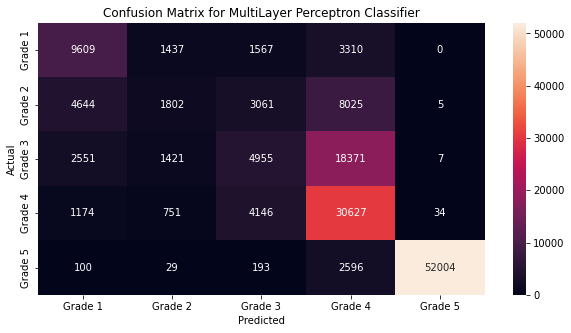

In [ ]:
conf_mat = pd.DataFrame(confusion_matrix(y_test,predictions_test_clf), columns=np.unique(y_test), index = np.unique(y_test))
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'

plt.figure(figsize=(10,5))

sns.heatmap(conf_mat, annot=True, fmt='d')

plt.title("Confusion Matrix for MultiLayer Perceptron Classifier")
plt.show()

In [ ]:
print("Classification Report MultiLayer Perceptron Classifier")
print(classification_report(y_test, predictions_test_clf))

Classification Report MultiLayer Perceptron Classifier
              precision    recall  f1-score   support

     Grade 1       0.53      0.60      0.57     15923
     Grade 2       0.33      0.10      0.16     17537
     Grade 3       0.36      0.18      0.24     27305
     Grade 4       0.49      0.83      0.61     36732
     Grade 5       1.00      0.95      0.97     54922

    accuracy                           0.65    152419
   macro avg       0.54      0.53      0.51    152419
weighted avg       0.63      0.65      0.62    152419



In [ ]:
rf = RandomForestClassifier()
rf.fit(x_train_pca,y_train)

predictions_train_rf = rf.predict(x_train_pca)
train_accuracy_rf = accuracy_score(y_train,predictions_train_rf)
print("Training Accuracy",train_accuracy_rf)

predictions_test_rf = rf.predict(x_test_pca)
test_accuracy_rf = accuracy_score(y_test,predictions_test_rf)
print("Testing Accuracy",test_accuracy_rf)

Training Accuracy 0.9445097798007135
Testing Accuracy 0.6240035691088381


Confusion Matrix and Classification Report

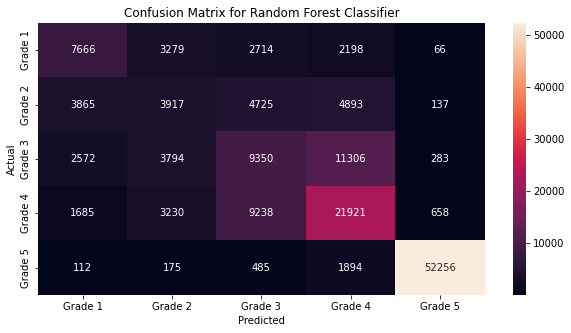

In [ ]:
conf_mat = pd.DataFrame(confusion_matrix(y_test,predictions_test_rf), columns=np.unique(y_test), index = np.unique(y_test))
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'

plt.figure(figsize=(10,5))

sns.heatmap(conf_mat, annot=True, fmt='d')

plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()

In [ ]:
print("Classification Report Random Forest Classifier")
print(classification_report(y_test, predictions_test_rf))

Classification Report Random Forest Classifier
              precision    recall  f1-score   support

     Grade 1       0.48      0.48      0.48     15923
     Grade 2       0.27      0.22      0.25     17537
     Grade 3       0.35      0.34      0.35     27305
     Grade 4       0.52      0.60      0.56     36732
     Grade 5       0.98      0.95      0.96     54922

    accuracy                           0.62    152419
   macro avg       0.52      0.52      0.52    152419
weighted avg       0.62      0.62      0.62    152419



From the above,classification reports and confusion matrices, we can see observe the following:


*   Mutlilayer Peceptron is giving the highest accuracy i.e 65% amongst the three classifiers
*   There is high correlation between the actual and predicted values of grade 5 and grade 4 damage.



From the above observations, we will further try to find best parameters for our random forest classifier to get more accurate results. We will be using Grid search cv to find best params

In [ ]:
# Create the parameter grid
param_grid = {
    'bootstrap': [True],
    'max_depth': [95,100],
    'max_features': [2, 3],
    'min_samples_leaf': [2,3],
    'n_estimators': [50,100]
}

# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, verbose = 2)

In [ ]:
grid_search.fit(x_train,y_train)

best_grid = grid_search.best_estimator_
print(best_grid)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END bootstrap=True, max_depth=95, max_features=2, min_samples_leaf=2, n_estimators=50; total time=  25.2s
[CV] END bootstrap=True, max_depth=95, max_features=2, min_samples_leaf=2, n_estimators=50; total time=  23.9s
[CV] END bootstrap=True, max_depth=95, max_features=2, min_samples_leaf=2, n_estimators=50; total time=  24.0s
[CV] END bootstrap=True, max_depth=95, max_features=2, min_samples_leaf=2, n_estimators=100; total time=  45.5s
[CV] END bootstrap=True, max_depth=95, max_features=2, min_samples_leaf=2, n_estimators=100; total time=  43.7s
[CV] END bootstrap=True, max_depth=95, max_features=2, min_samples_leaf=2, n_estimators=100; total time=  43.2s
[CV] END bootstrap=True, max_depth=95, max_features=2, min_samples_leaf=3, n_estimators=50; total time=  19.8s
[CV] END bootstrap=True, max_depth=95, max_features=2, min_samples_leaf=3, n_estimators=50; total time=  19.9s
[CV] END bootstrap=True, max_depth=95, max_featu

Fitting the training set again on random forest classifier with best params 

In [ ]:
rf_cv =RandomForestClassifier(random_state=42,max_depth=95, max_features=3, min_samples_leaf=3,
                       min_samples_split=10, n_estimators=200)
rf_cv.fit(x_train,y_train)

predictions_train_rf_gcv = rf_cv.predict(x_train)
train_accuracy_rf_gcv = accuracy_score(y_train,predictions_train_rf_gcv)
print("Training Accuracy",train_accuracy_rf_gcv)

predictions_test_rf_gcv = rf_cv.predict(x_test)
test_accuracy_rf_gcv = accuracy_score(y_test,predictions_test_rf_gcv)
print("Testing Accuracy",test_accuracy_rf_gcv)

Training Accuracy 0.7139525156845861
Testing Accuracy 0.6557122143564779


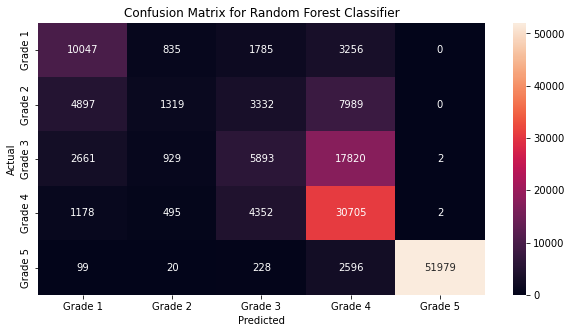

In [ ]:
conf_mat = pd.DataFrame(confusion_matrix(y_test,predictions_test_rf_gcv), columns=np.unique(y_test), index = np.unique(y_test))
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'

plt.figure(figsize=(10,5))

sns.heatmap(conf_mat, annot=True, fmt='d')

plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()

In [ ]:
print("Classification Report Random Forest Classifier")
print(classification_report(y_test, predictions_test_rf_gcv))

Classification Report Random Forest Classifier
              precision    recall  f1-score   support

     Grade 1       0.53      0.63      0.58     15923
     Grade 2       0.37      0.08      0.12     17537
     Grade 3       0.38      0.22      0.27     27305
     Grade 4       0.49      0.84      0.62     36732
     Grade 5       1.00      0.95      0.97     54922

    accuracy                           0.66    152419
   macro avg       0.55      0.54      0.51    152419
weighted avg       0.64      0.66      0.62    152419



We can see that the accuracy of our model slighlty increased to 66% from 62%.

## **PART 2**
## **Predicting Household Level Impact**

Among the tables of the dataset, the four tables listed below contain detailed information about the household structure and the change in assets post the earthquake on a per-household level. Some examples of features are - land before the earthquake, land after the earthquake, cable before the earthquake, cable after the earthquake, etc.. Additionally, there were also columns about the count of education drops per household clearly indicating that unfortunately, because of the impact of the earthquake, the family could no longer afford to send their children to school. 

Looking at the dataset, we were very interested in determining which households were more severely impacted by the earthquake and which were relatively less impacted. 



Tables - 


*   Household Demographics Table
*   Household Resources Table 
*   Household Earthquake Impact Table
*   Individual Demographics Table





#### **Household Demographics Table - Data Extraction and Cleaning**


This table contains information about each household. Here, in addition to the household ID, there are columns like district_id, vdcmun_id and ward_id. To understand this, it may be helpful to understand that in Nepal, districts are subdivided into localities known as Village Development Committees (VDCs). These are further subdivided into wards. 

In [ ]:
household_demographics_df = pd.read_csv("./csv_household_demographics.csv")
household_demographics_df.head(5)

,household_id,district_id,vdcmun_id,ward_id,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household
0,12010100001101,12,1207,120703,Male,31.0,Rai,Illiterate,Rs. 10 thousand,3.0,0.0
1,12010100002101,12,1207,120703,Female,62.0,Rai,Illiterate,Rs. 10 thousand,6.0,0.0
2,12010100003101,12,1207,120703,Male,51.0,Gharti/Bhujel,Illiterate,Rs. 10 thousand,13.0,0.0
3,12010100004101,12,1207,120703,Male,48.0,Gharti/Bhujel,Illiterate,Rs. 10 thousand,5.0,0.0
4,12010100005101,12,1207,120703,Male,70.0,Gharti/Bhujel,Illiterate,Rs. 10 thousand,8.0,0.0


In [ ]:
household_demographics_df = household_demographics_df.dropna()

For exploring and getting a preliminary sense of the data, we are plotting some count plots.

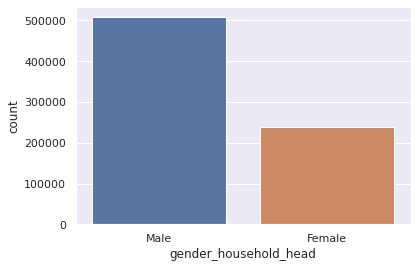

In [ ]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="gender_household_head", data=household_demographics_df)

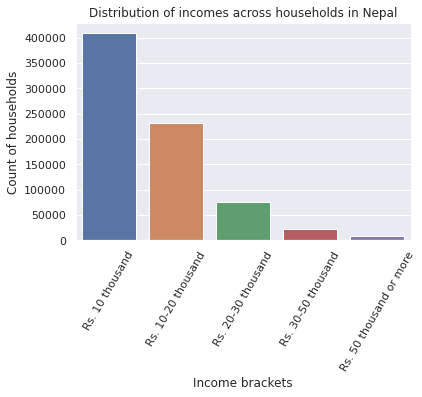

In [ ]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="income_level_household", data=household_demographics_df)
ax.set_title('Distribution of incomes across households in Nepal')
ax.set_xlabel('Income brackets')
ax.set_ylabel('Count of households')
ax.tick_params(axis='x', rotation=60)

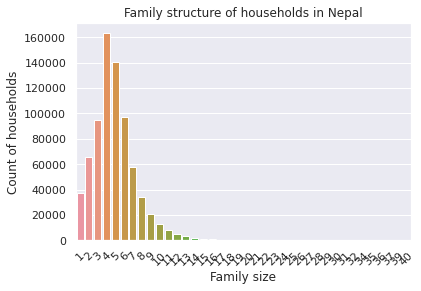

In [ ]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="size_household", data=household_demographics_df)
ax.set_title('Family structure of households in Nepal')
ax.set_xlabel('Family size')
ax.set_ylabel('Count of households')
ax.tick_params(axis='x', rotation=45)

In [ ]:
## Dropping columns 

## Here, vdcmun_id and ward_id are granular level details which will not be used in our analysis. 
## Also, Age Household head, Caste Household and Is Bank Account Present in the Household are factors which are very unlikely to contribute towards our problem statement 

household_demographics_df = household_demographics_df.drop(columns = ['vdcmun_id', 'ward_id', 'age_household_head',	'caste_household', 'is_bank_account_present_in_household'])

In [ ]:
# Cast size_household to Int 

household_demographics_df['size_household'] = household_demographics_df['size_household'].astype(int)

In [ ]:
## Let us analyze the values in the column education_level_household_head

household_demographics_df['education_level_household_head'].value_counts()

Illiterate                    263157
Non-formal education          157724
Class 5                        45267
SLC or equivalent              42988
Intermediate or equivalent     29181
Class 4                        27836
Class 8                        27520
Class 3                        26217
Class 10                       24097
Class 2                        22331
Class 7                        21460
Class 6                        17099
Class 9                        12184
Bachelors or equivalent        10925
Class 1                         9996
Masters or equivalent           4507
Other                           2838
Nursery/K.G./Kindergarten       1741
Ph.D. or equivalent               69
Name: education_level_household_head, dtype: int64

As can be seen there are many different classes of education levels. **We have a hypothesis that the education level of the household head could determine the income level of the household, which could in turn diminish the severity of the impact for the household.**

As there are many categories, we are creating mappings for the different education levels as follows - 

In [ ]:
def categorize(x):
  if x['education_level_household_head']=="Nursery/K.G./Kindergarten" or x['education_level_household_head']=="Class 1" or x['education_level_household_head']=="Class 2" or x['education_level_household_head']=="Class 3" or x['education_level_household_head']=="Class 4" or x['education_level_household_head']=="Class 5":
    return "Primary"
  elif x['education_level_household_head']=="Class 6" or x['education_level_household_head']=="Class 7" or x['education_level_household_head']=="Class 8" or x['education_level_household_head']=="Class 9" or x['education_level_household_head']=="Class 10" or x['education_level_household_head']=="SLC or equivalent" or x['education_level_household_head']=="Intermediate or equivalent":
    return "Secondary"
  elif x['education_level_household_head']=="Bachelors or equivalent" or x['education_level_household_head']=="Masters or equivalent":
    return "University"
  elif x['education_level_household_head']=="Illiterate":
    return "Illiterate"
  else:
    return "Others"
    
household_demographics_df['education_level_household_head'] = household_demographics_df.apply(lambda x: categorize(x), axis=1)

In [ ]:
household_demographics_df['education_level_household_head'].value_counts()

Illiterate    263157
Secondary     174529
Others        160631
Primary       133388
University     15432
Name: education_level_household_head, dtype: int64

In [ ]:
household_demographics_df.head(10)

,household_id,district_id,gender_household_head,education_level_household_head,income_level_household,size_household
0,12010100001101,12,Male,Illiterate,Rs. 10 thousand,3
1,12010100002101,12,Female,Illiterate,Rs. 10 thousand,6
2,12010100003101,12,Male,Illiterate,Rs. 10 thousand,13
3,12010100004101,12,Male,Illiterate,Rs. 10 thousand,5
4,12010100005101,12,Male,Illiterate,Rs. 10 thousand,8
5,12010100006101,12,Male,Illiterate,Rs. 10 thousand,6
6,12010100007101,12,Male,Primary,Rs. 10-20 thousand,5
7,12010100008101,12,Male,Primary,Rs. 10 thousand,5
8,12010100009101,12,Male,Illiterate,Rs. 10 thousand,9
9,12010100010101,12,Male,Illiterate,Rs. 10 thousand,6


In [ ]:
household_demographics_df.shape

(747137, 6)

#### **Household Resources Table - Data Extraction and Cleaning**

The Household Resources Table details out the associated assets for each household. Assets include Land, TV, Cable, Computer, Internet, Telephone, Mobile Phone, Fridge, Motorcycle, Four Wheeler for Family Use and Four Wheeler for Commerical use. 

It is interesting to note that the data also elaborates on all these assets by recording their state pre and post the earthquake. 

**Our analysis uses these pre and post conditions as a measure to estimate the damage incurred on the household. For example, there are rows where has_asset_land_pre_eq is 1 & has_asset_land_post_eq is 0. This implies that the family had to sell off their land and were severely impacted** (Ofcourse, this has the underlying assumption that no other reason motivated them to sell it, and for the purposes of our analysis we are assuming so). 

In [ ]:
household_resources_df = pd.read_csv("./csv_household_resources.csv")
household_resources_df.head(5)

,household_id,district_id,vdcmun_id,ward_id,source_water_pre_eq,source_water_post_eq,source_cooking_fuel_pre_eq,source_cooking_fuel_post_eq,source_light_pre_eq,source_light_post_eq,type_toilet_pre_eq,type_toilet_post_eq,has_asset_land_pre_eq,has_asset_tv_pre_eq,has_asset_cable_pre_eq,has_asset_computer_pre_eq,has_asset_internet_pre_eq,has_asset_telephone_pre_eq,has_asset_mobile_phone_pre_eq,has_asset_fridge_pre_eq,has_asset_motorcycle_pre_eq,has_asset_four_wheeler_family_use_pre_eq,has_asset_four_wheeler_commercial_use_pre_eq,has_asset_none_pre_eq,has_asset_land_post_eq,has_asset_tv_post_eq,has_asset_cable_post_eq,has_asset_computer_post_eq,has_asset_internet_post_eq,has_asset_telephone_post_eq,has_asset_mobile_phone_post_eq,has_asset_fridge_post_eq,has_asset_motorcycle_post_eq,has_asset_four_wheeler_family_use_post_eq,has_asset_four_wheeler_commercial_post_eq,has_asset_none_post_eq
0,12010100001101,12,1207,120703,Pipeline,Pipeline,Wood,Wood,Electricity,Electricity,Simple,Simple,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,12010100002101,12,1207,120703,Pipeline,Pipeline,Wood,Wood,Electricity,Electricity,Simple,Simple,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
2,12010100003101,12,1207,120703,Pipeline,Pipeline,Wood,Wood,Electricity,Electricity,Simple,Simple,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
3,12010100004101,12,1207,120703,Pipeline,Pipeline,Wood,Wood,Electricity,Electricity,Simple,Simple,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4,12010100005101,12,1207,120703,Pipeline,Pipeline,Wood,Wood,Electricity,Electricity,Simple,Flush-out lavatory with septic tank,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
## Dropping columns 

## Here, vdcmun_id and ward_id are granular level details which will not be used in our analysis. 

household_resources_df = household_resources_df.drop(columns = ['district_id', 'vdcmun_id', 'ward_id', 'source_water_pre_eq', 'source_water_post_eq', 'source_cooking_fuel_pre_eq', 'source_cooking_fuel_post_eq', 'source_light_pre_eq', 'source_light_post_eq', 'type_toilet_pre_eq', 'type_toilet_post_eq'])

In [ ]:
## Drop NULL Values

household_resources_df = household_resources_df.dropna()

This is one of the most crucial aspects for the analysis of this problem. Here, we are measuring the impact on the household in terms of the changes observed pre and post the earthquake for all assets. 

In [ ]:
## Measuring Impact 

def measuring_land_change(x):
  if (x['has_asset_land_pre_eq']==1 and x['has_asset_land_post_eq']==1):
    return 1
  else:
    return 0


def measuring_tv_change(x):
  if (x['has_asset_tv_pre_eq']==1 and x['has_asset_tv_post_eq']==1):
    return 1
  else:
    return 0


def measuring_cable_change(x):
  if (x['has_asset_cable_pre_eq']==1 and x['has_asset_cable_post_eq']==1):
    return 1
  else:
    return 0


def measuring_computer_change(x):
  if (x['has_asset_computer_pre_eq']==1 and x['has_asset_computer_post_eq']==1):
    return 1
  else:
    return 0


def measuring_internet_change(x):
  if (x['has_asset_internet_pre_eq']==1 and x['has_asset_internet_post_eq']==1):
    return 1
  else:
    return 0


def measuring_telephone_change(x):
  if (x['has_asset_telephone_pre_eq']==1 and x['has_asset_telephone_post_eq']==1):
    return 1
  else:
    return 0


def measuring_mobile_change(x):
  if (x['has_asset_mobile_phone_pre_eq']==1 and x['has_asset_mobile_phone_post_eq']==1):
    return 1
  else:
    return 0


def measuring_fridge_change(x):
  if (x['has_asset_fridge_pre_eq']==1 and x['has_asset_fridge_post_eq']==1):
    return 1
  else:
    return 0


def measuring_motorcycle_change(x):
  if (x['has_asset_motorcycle_pre_eq']==1 and x['has_asset_motorcycle_post_eq']==1):
    return 1
  else:
    return 0


def measuring__four_wheeler_family_use_change(x):
  if (x['has_asset_four_wheeler_family_use_pre_eq']==1 and x['has_asset_four_wheeler_family_use_post_eq']==1):
    return 1
  else:
    return 0

def four_wheeler_commercial_use_change(x):
  if (x['has_asset_four_wheeler_commercial_use_pre_eq']==1 and x['has_asset_four_wheeler_commercial_post_eq']==1):
    return 1
  else:
    return 0

household_resources_df['land_change'] = household_resources_df.apply(lambda x:measuring_land_change(x), axis=1)
household_resources_df['tv_change'] = household_resources_df.apply(lambda x:measuring_tv_change(x), axis=1)
household_resources_df['cable_change'] = household_resources_df.apply(lambda x:measuring_cable_change(x), axis=1)
household_resources_df['computer_change'] = household_resources_df.apply(lambda x:measuring_computer_change(x), axis=1)
household_resources_df['internet_change'] = household_resources_df.apply(lambda x:measuring_internet_change(x), axis=1)
household_resources_df['telephone_change'] = household_resources_df.apply(lambda x:measuring_telephone_change(x), axis=1)
household_resources_df['mobile_change'] = household_resources_df.apply(lambda x:measuring_mobile_change(x), axis=1)
household_resources_df['fridge_change'] = household_resources_df.apply(lambda x:measuring_fridge_change(x), axis=1)
household_resources_df['motorcycle_change'] = household_resources_df.apply(lambda x:measuring_motorcycle_change(x), axis=1)
household_resources_df['four_wheeler_family_use_change'] = household_resources_df.apply(lambda x:measuring__four_wheeler_family_use_change(x), axis=1)
household_resources_df['four_wheeler_commercial_use_change'] = household_resources_df.apply(lambda x:four_wheeler_commercial_use_change(x), axis=1)

In [ ]:
## Drop columns

household_resources_df = household_resources_df.drop(columns=['has_asset_land_pre_eq', 'has_asset_land_post_eq', 'has_asset_tv_pre_eq', 'has_asset_tv_post_eq', 'has_asset_cable_pre_eq', 'has_asset_cable_post_eq', 'has_asset_computer_pre_eq', 'has_asset_computer_post_eq', 'has_asset_internet_pre_eq', 'has_asset_internet_post_eq', 'has_asset_telephone_pre_eq', 'has_asset_telephone_post_eq', 'has_asset_mobile_phone_pre_eq', 'has_asset_mobile_phone_post_eq', 'has_asset_fridge_pre_eq', 'has_asset_fridge_post_eq', 'has_asset_motorcycle_pre_eq', 'has_asset_motorcycle_post_eq', 'has_asset_four_wheeler_family_use_pre_eq', 'has_asset_four_wheeler_family_use_post_eq', 'has_asset_four_wheeler_commercial_use_pre_eq', 'has_asset_four_wheeler_commercial_post_eq', 'has_asset_none_pre_eq', 'has_asset_none_post_eq'])

In [ ]:
household_resources_df.head(5)

,household_id,land_change,tv_change,cable_change,computer_change,internet_change,telephone_change,mobile_change,fridge_change,motorcycle_change,four_wheeler_family_use_change,four_wheeler_commercial_use_change
0,12010100001101,1,0,0,0,0,0,1,0,0,0,0
1,12010100002101,1,0,0,0,0,0,1,0,0,0,0
2,12010100003101,1,0,0,0,0,0,1,0,0,0,0
3,12010100004101,1,0,0,0,0,0,1,0,0,0,0
4,12010100005101,1,0,0,0,0,0,1,0,0,0,0


In [ ]:
household_resources_df.shape

(747365, 12)

#### **Household Earthquake Impact Table - Data Extraction and Cleaning**






The Household Earthquake Impact Table is an important table for analysing the earthquake impact on each household. 

Here, several columns are indicators of the impact. For instance, shelter_condition_household_post_eq contains values like "Staying in their own house", as well as other values like "Temporary shelter" or "Rent". These are clear indicators of the severity of the impact felt by the household as, even a whole year after the tragedy several families could not recover.  



There are other columns as well indicating the pre and post earthquake conditions - count of deaths, count of injuries, count of education drops, count of pregnancy treatment drops, count of vaccination drops and occupation changes in the past 12 months. As may be seen, these columns also are indicative of the household-level impact. 

In [ ]:
household_earthquake_impact_df = pd.read_csv("./csv_household_earthquake_impact.csv")
household_earthquake_impact_df.head(5)

,household_id,district_id,vdcmun_id,ward_id,shelter_condition_household_post_eq,residence_household_pre_eq,residence_household_post_eq,household_eq_id_type,has_death_occurred_last_12_months,count_death_last_12_months,has_injury_loss_occurred_last_12_months,count_injury_loss_last_12_months,has_education_drop_occurred_last_12_months,count_education_drop_last_12_months,has_pregnancy_treatment_drop_occurred_last_12_months,count_pregnancy_treatment_drop_last_12_months,has_vaccination_drop_occurred_last_12_months,count_vaccination_drop_last_12_months,has_occupation_change_occurred_last_12_months,count_occupation_change_last_12_months,residence_district_household_head_pre_eq,residence_district_household_head_post_eq,is_recipient_rahat_15k,is_recipient_rahat_10k,is_recipient_rahat_200k,is_recipient_rahat_social_security_3k,is_recipient_rahat_none,is_ineligible_rahat
0,12010100001101,12,1207,120703,Staying in their own house,This VDC/Municipality,This VDC/Municipality,ID Card for Total Destruction,0.0,NaN,0.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1,1,0,0,0,0
1,12010100002101,12,1207,120703,Staying in their own house,This VDC/Municipality,This VDC/Municipality,Have not received ID Card,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0,0,0,0,1,0
2,12010100003101,12,1207,120703,Staying in their own house,This VDC/Municipality,This VDC/Municipality,Have not received ID Card,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0,0,0,0,1,0
3,12010100004101,12,1207,120703,Staying in their own house,This VDC/Municipality,This VDC/Municipality,Have not received ID Card,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0,0,0,0,1,0
4,12010100005101,12,1207,120703,Staying in their own house,This VDC/Municipality,This VDC/Municipality,Have not received ID Card,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0,0,0,0,1,0


In [ ]:
household_earthquake_impact_df = household_earthquake_impact_df.drop(columns = ['district_id', 'vdcmun_id', 'ward_id', 'residence_household_pre_eq',	'residence_household_post_eq', 'household_eq_id_type', 'residence_district_household_head_pre_eq', 'residence_district_household_head_post_eq', 'is_recipient_rahat_15k', 'is_recipient_rahat_10k', 'is_recipient_rahat_200k', 'is_recipient_rahat_social_security_3k', 'is_recipient_rahat_none', 'is_ineligible_rahat'])

In [ ]:
household_earthquake_impact_df = household_earthquake_impact_df.drop(columns = ['has_death_occurred_last_12_months', 'count_death_last_12_months', 'has_injury_loss_occurred_last_12_months', 'count_injury_loss_last_12_months', 'has_pregnancy_treatment_drop_occurred_last_12_months', 'count_pregnancy_treatment_drop_last_12_months', 'has_vaccination_drop_occurred_last_12_months', 'count_vaccination_drop_last_12_months'])

**For the purpose of our analysis, we wanted to especially focus on the count of education drop and the count of occupation change per hosuehold.** 


In [ ]:
# Merge 'has_education_drop_occurred_last_12_months' column with 'count_education_drop_last_12_months' column 
# Here, has_education_drop_occurred_last_12_months is a Boolean value 0/1 and count_education_drop_last_12_months is the count

def mergeCountEducationDropColumn(x):
  if (x['has_education_drop_occurred_last_12_months']==0.0):
    return 0
  else :
    return x['count_education_drop_last_12_months']

household_earthquake_impact_df['count_education_drop_last_12_months'] = household_earthquake_impact_df.apply(lambda x : mergeCountEducationDropColumn(x), axis=1)

# Drop column 'has_education_drop_occurred_last_12_months' and rename 'count_education_drop_last_12_months' to 'count_education_drop' (For convenience)
household_earthquake_impact_df = household_earthquake_impact_df.drop(columns = ['has_education_drop_occurred_last_12_months'])
household_earthquake_impact_df = household_earthquake_impact_df.rename(columns={'count_education_drop_last_12_months':'count_education_drop'})

In [ ]:
# Merge 'has_occupation_change_occurred_last_12_months' column with 'count_occupation_change_last_12_months' column 
# Here, has_occupation_change_occurred_last_12_months is a Boolean value 0/1 and count_occupation_change_last_12_months is the count

def mergeCountOccupationChangeColumn(x):
  if (x['has_occupation_change_occurred_last_12_months']==0.0):
    return 0
  elif (x['has_occupation_change_occurred_last_12_months']==np.nan):
    return np.nan
  else :
    return x['count_occupation_change_last_12_months']

household_earthquake_impact_df['count_occupation_change_last_12_months'] = household_earthquake_impact_df.apply(lambda x : mergeCountOccupationChangeColumn(x), axis=1)

# Drop column 'has_occupation_change_occurred_last_12_months' and rename 'count_occupation_change_last_12_months' to 'count_occupation_change' (For convenience)
household_earthquake_impact_df = household_earthquake_impact_df.drop(columns = ['has_occupation_change_occurred_last_12_months'])
household_earthquake_impact_df = household_earthquake_impact_df.rename(columns={'count_occupation_change_last_12_months':'count_occupation_change'})

In [ ]:
household_earthquake_impact_df = household_earthquake_impact_df.dropna()

In [ ]:
household_earthquake_impact_df.head(5)

,household_id,shelter_condition_household_post_eq,count_education_drop,count_occupation_change
0,12010100001101,Staying in their own house,1.0,0.0
2,12010100003101,Staying in their own house,0.0,0.0
3,12010100004101,Staying in their own house,0.0,0.0
4,12010100005101,Staying in their own house,0.0,0.0
5,12010100006101,Staying in their own house,0.0,0.0


It is interesting to also observe the living conditions of the households post the earthquake.

In [ ]:
household_earthquake_impact_df['shelter_condition_household_post_eq'].value_counts()

Temporary shelter                                  269403
Staying in their own house                         205036
Staying in rent                                     33236
Others                                              13088
Staying in Organization/relative/friend’s house      6993
Name: shelter_condition_household_post_eq, dtype: int64

In [ ]:
household_earthquake_impact_df.shape

(527756, 4)

#### **Individual Demographics Table - Data Extraction and Cleaning**



The dataset also contains a table enlisting the individuals across households. This table has several interesting features such as presence_in_household, education_level_individual, marital_status_individual, etc..

However, we do not expect any of these columns/information to be utilized in our dataset. 

In [ ]:
ind_demographics_df = pd.read_csv("./csv_individual_demographics.csv")
ind_demographics_df.head(5)

,individual_id,district_id,vdcmun_id,ward_id,gender_individual,age_individual,presence_in_household,disability_individual,has_registered_birth,education_level_individual,marital_status_individual
0,12010100001101001,12,1207,120703,Male,31,Mostly Present,No,NaN,Illiterate,Married
1,12010100001101002,12,1207,120703,Female,58,Mostly Present,No,NaN,Illiterate,Married
2,12010100001101003,12,1207,120703,Male,15,Mostly Present,No,NaN,Class 7,Not Married
3,12010100002101001,12,1207,120703,Female,62,Mostly Present,No,NaN,Illiterate,Widow/Widower
4,12010100002101002,12,1207,120703,Male,23,Not present-Abroad,No,NaN,Class 6,Married


In [ ]:
# Drop columns - 'disability_individual',	'has_registered_birth' & 'marital_status_individual'

ind_demographics_df = ind_demographics_df.drop(columns=['vdcmun_id', 'ward_id', 'disability_individual','has_registered_birth','marital_status_individual'])

In [ ]:
ind_demographics_df = ind_demographics_df.dropna()

In [ ]:
ind_demographics_df['presence_in_household'].value_counts()

Mostly Present              2637279
Not present-Same Country     536371
Not present-Abroad           190388
Not Known                        10
Name: presence_in_household, dtype: int64

In [ ]:
ind_demographics_df.shape

(3364048, 6)

In [ ]:
ind_demographics_df.describe()

,individual_id,district_id,age_individual
count,3.364048e+06,3.364048e+06,3.364048e+06
mean,2.605749e+16,2.575012e+01,3.095755e+01
std,5.787632e+15,5.793465e+00,1.900773e+01
min,1.201010e+16,1.200000e+01,5.000000e+00
25%,2.217010e+16,2.200000e+01,1.600000e+01
50%,2.463020e+16,2.400000e+01,2.700000e+01
75%,3.037050e+16,3.000000e+01,4.300000e+01
max,3.667090e+16,3.600000e+01,1.220000e+02


#### **Feature Engineering - Getting the dataset ready for Modelling**

For our analysis, we wish to find out the impact per household based on several factors that we have computed above. As can be observed, we would have to generate a combined dataframe to perform the analysis. 

Household ID, present in all tables, allows us to join across tables. In this section, we will perform **Record Linking** and create a final combined dataframe to perform the analysis. 



In [ ]:
join_query = '''SELECT * FROM household_demographics_df JOIN household_earthquake_impact_df ON 
household_demographics_df.household_id = household_earthquake_impact_df.household_id'''

joined_df = ps.sqldf(join_query, locals())

In [ ]:
combine_query = '''SELECT * FROM joined_df JOIN household_resources_df ON 
joined_df.household_id = household_resources_df.household_id'''

combined_df = ps.sqldf(combine_query, locals())

In [ ]:
combined_df = combined_df.drop(columns=['household_id'])

In [ ]:
combined_df = combined_df.dropna()

In [ ]:
combined_df['education_change'] = combined_df['count_education_drop'].apply(lambda x: 1 if x!=0 else 0)
combined_df['occ_change'] = combined_df['count_occupation_change'].apply(lambda x: 1 if x!=0 else 0)

In [ ]:
combined_df = combined_df.drop(columns=['count_education_drop', 'count_occupation_change'])

In [ ]:
combined_df.head(5)

,district_id,gender_household_head,education_level_household_head,income_level_household,size_household,shelter_condition_household_post_eq,land_change,tv_change,cable_change,computer_change,internet_change,telephone_change,mobile_change,fridge_change,motorcycle_change,four_wheeler_family_use_change,four_wheeler_commercial_use_change,education_change,occ_change
0,12,Male,Illiterate,Rs. 10 thousand,3,Staying in their own house,1,0,0,0,0,0,1,0,0,0,0,1,0
1,12,Male,Illiterate,Rs. 10 thousand,13,Staying in their own house,1,0,0,0,0,0,1,0,0,0,0,0,0
2,12,Male,Illiterate,Rs. 10 thousand,5,Staying in their own house,1,0,0,0,0,0,1,0,0,0,0,0,0
3,12,Male,Illiterate,Rs. 10 thousand,8,Staying in their own house,1,0,0,0,0,0,1,0,0,0,0,0,0
4,12,Male,Illiterate,Rs. 10 thousand,6,Staying in their own house,1,0,0,0,0,0,1,0,0,0,0,0,0


After joining across all tables, we now have several columns containing boolean values 0 and 1 indicating whether the household was impacted in that particular area. 

Naturally, we would like to compute the cumulative Impact Factor to understand the impact faced by the households. 

In [ ]:
combined_df['total_if'] = combined_df['land_change'] + combined_df['tv_change'] + combined_df['cable_change'] + combined_df['computer_change'] + combined_df['internet_change'] + combined_df['telephone_change'] + combined_df['mobile_change'] + combined_df['fridge_change'] + combined_df['motorcycle_change'] + combined_df['four_wheeler_family_use_change'] + combined_df['four_wheeler_commercial_use_change'] + combined_df['education_change'] + combined_df['occ_change'] 

combined_df = combined_df.drop(columns=['land_change',	'tv_change',	'cable_change',	'computer_change',	'internet_change',	'telephone_change',	'mobile_change',	'fridge_change',	'motorcycle_change',	'four_wheeler_family_use_change',	'four_wheeler_commercial_use_change',	'education_change',	'occ_change'])

In [ ]:
combined_df = pd.get_dummies(combined_df,columns=['education_level_household_head','income_level_household', 'shelter_condition_household_post_eq'])

In [ ]:
combined_df = combined_df.rename(columns={'income_level_household_Rs. 10 thousand':'Rs.10k'})
combined_df = combined_df.rename(columns={'income_level_household_Rs. 10-20 thousand':'Rs.10_20k'})
combined_df = combined_df.rename(columns={'income_level_household_Rs. 20-30 thousand':'Rs.20_30k'})
combined_df = combined_df.rename(columns={'income_level_household_Rs. 30-50 thousand':'Rs.30_50k'})
combined_df = combined_df.rename(columns={'income_level_household_Rs. 50 thousand or more':'Above_50k'})
combined_df = combined_df.rename(columns={'shelter_condition_household_post_eq_Others	':'shelter_others'})
combined_df = combined_df.rename(columns={'shelter_condition_household_post_eq_Staying in Organization/relative/friend’s house':'shelter_rel/friend'})
combined_df = combined_df.rename(columns={'shelter_condition_household_post_eq_Staying in rent':'shelter_rent'})
combined_df = combined_df.rename(columns={'shelter_condition_household_post_eq_Staying in their own house':'shelter_own'})
combined_df = combined_df.rename(columns={'shelter_condition_household_post_eq_Temporary shelter':'shelter_temp'})

In [ ]:
## Rearranging the columns 

combined_df = combined_df[['district_id', 'gender_household_head', 'size_household', 'education_level_household_head_Illiterate', 'education_level_household_head_Others', 'education_level_household_head_Primary', 'education_level_household_head_Secondary', 'education_level_household_head_University', 'Rs.10k', 'Rs.10_20k', 'Rs.20_30k', 'Rs.30_50k', 'Above_50k', 'shelter_condition_household_post_eq_Others', 'shelter_rel/friend', 'shelter_rent', 'shelter_own', 'shelter_temp', 'total_if']]

As per our calculation, the computed Impact Factor values will be in the range of 0-14. 

This is because we have used 14 different attributes to measure the impact, in values of 0s or 1s. In the worst case (for a severely impacted family), the maximum value of the impact factor would be 14 and in the best case (unimpacted family), the minimum value of the impact factor would be 0. 

Here, rather than predicting the exact Impact Factor value, we are more interested in learning about the grade of impact. To do this, we have created different bins of data (size 2), from Grade 1 to Grade 7. Grade 1 indicates little to no damage and Grade 7 denotes severe impact and damage. 

In [ ]:
def binImpactFactor(x):
  if (x<=2):
    return "Grade 1"
  elif (x<=4):
    return "Grade 2"
  elif (x<=6):
    return "Grade 3"
  elif (x<=8):
    return "Grade 4"
  elif (x<=10):
    return "Grade 5"
  elif (x<=12):
    return "Grade 6"
  else:
    return "Grade 7"

combined_df['if'] = combined_df['total_if'].apply(lambda x: binImpactFactor(x))

In [ ]:
combined_df = combined_df.drop(columns = ['total_if'])

**This is the final combined dataframe, ready for the modelling stage.**

In [ ]:
combined_df.head(5)

,district_id,gender_household_head,size_household,education_level_household_head_Illiterate,education_level_household_head_Others,education_level_household_head_Primary,education_level_household_head_Secondary,education_level_household_head_University,Rs.10k,Rs.10_20k,Rs.20_30k,Rs.30_50k,Above_50k,shelter_condition_household_post_eq_Others,shelter_rel/friend,shelter_rent,shelter_own,shelter_temp,if
0,12,Male,3,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,Grade 2
1,12,Male,13,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,Grade 1
2,12,Male,5,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,Grade 1
3,12,Male,8,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,Grade 1
4,12,Male,6,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,Grade 1


Segregating the Features and the Labels into separate dataframes. 

In [ ]:
features = combined_df[['size_household', 'education_level_household_head_Illiterate', 'education_level_household_head_Others', 'education_level_household_head_Primary', 'education_level_household_head_Secondary', 'education_level_household_head_University', 'Rs.10k', 'Rs.10_20k', 'Rs.20_30k', 'Rs.30_50k', 'Above_50k']]
labels = combined_df[['if']]

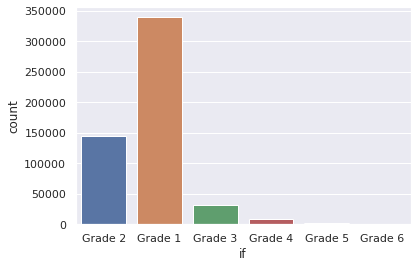

In [ ]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="if", data=labels)

This bell-shaped histogram plot is close to how we expected it to be. From this, we can conclude that a majority of the families experienced moderate degree of damage. And, some families on the extreme end, especially Grade 4,5 and 6, unfortunately, experienced a higher degree of impact. 

#### **Combined Exploratory Data Analysis**



**Goal** - Evaluate the post earthquake residential status of households 


**Conclusion** - It can be seen from the graph that a major portion of households were still living in temporary shelters, 1 year after the earthquake.



Text(0.5, 0, 'Count of households')

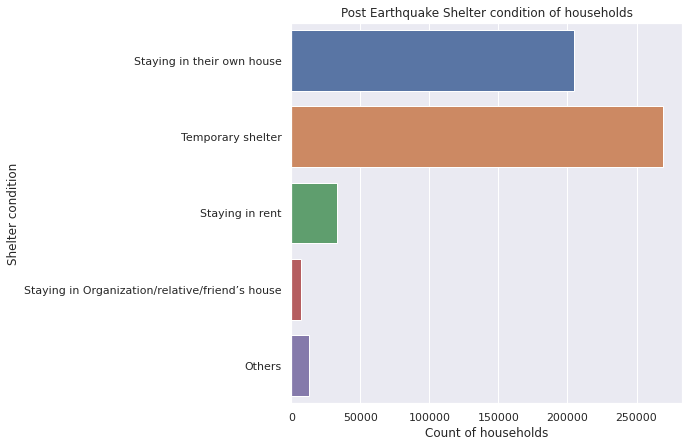

In [ ]:
plt.figure(figsize=(7,7))
ax = sns.countplot(y="shelter_condition_household_post_eq", data=household_earthquake_impact_df)
ax.set_title('Post Earthquake Shelter condition of households')
ax.set_ylabel('Shelter condition')
ax.set_xlabel('Count of households')

#### **Model Training and Prediction**

Split the dataset into training and testing.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

Standardizing x_train and x_test subsets.

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

#### **Decision Tree Classifier**

A decision tree is a flowchart-like tree structure where an internal node represents feature(or attribute), the branch represents a decision rule, and each leaf node represents the outcome. The topmost node in a decision tree is known as the root node. It learns to partition on the basis of the attribute value. It partitions the tree in recursively manner call recursive partitioning. 

As our data is solving a Classification problem, we wanted to use Decision Trees. Decision Trees can easily capture non-linear information and has no assumptions about distribution because of the non-parametric nature of the algorithm.

In [ ]:
decisionTreeModel = DecisionTreeClassifier(random_state=0)
decisionTreeModel.fit(X_train,y_train)
predictions = decisionTreeModel.predict(X_test)

test_accuracy = accuracy_score(y_test,predictions)
print(test_accuracy)

0.6547673184780961


**With the Decision Tree Classifier, our model achieves 65.4% accuracy.**

#### **MLP Classifier**

In the Multilayer perceptron, there can more than one linear layer (combinations of neurons). In a supervised classification system, each input vector is associated with a label, or ground truth, defining its class or class label is given with the data. The output of the network gives a class score, or prediction, for each input.

MLPs are suitable for classification prediction problems where inputs are assigned a class or label. They are very flexible and can be used generally to learn a mapping from inputs to outputs.


In [ ]:
def accuracy(confusion_matrix):
   diagonal_sum = confusion_matrix.trace()
   sum_of_all_elements = confusion_matrix.sum()
   return diagonal_sum / sum_of_all_elements

In [ ]:
from sklearn.neural_network import MLPClassifier

#Initializing the MLPClassifier
classifier = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)

In [ ]:
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_pred, y_test)

#Printing the accuracy
print("Accuracy of MLPClassifier : ", accuracy(cm))

Accuracy of MLPClassifier :  0.654956798544793


**With the MLP Classifier, our model achieves 65.4% accuracy**

#### **Gradient Boosting Classifier**

Gradient boosting classifiers are a group of machine learning algorithms that combine many weak learning models together to create a strong predictive model. Decision trees are usually used when doing gradient boosting. Gradient boosting models are becoming popular because of their effectiveness at classifying complex datasets.

For our implementation of the Gradient Boosting Classifier, we have tried 4 learning rates and it can be seen that the best accuracy is achieved with the learning rate of 0.1

In [ ]:
lr_list = [0.05, 0.075, 0.1]

for learning_rate in lr_list:
  
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  0.05
Accuracy score (training): 0.643
Accuracy score (validation): 0.643


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  0.075
Accuracy score (training): 0.643
Accuracy score (validation): 0.643


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  0.1
Accuracy score (training): 0.650
Accuracy score (validation): 0.651


**With the MLP Classifier, our model achieves 65.1% accuracy**

## **Conclusion**

**Summary and Overall Analysis**

In this notebook, we solved 2 challenging problem statements - 1. Predicting which buildings are more prone to damage. 2. Predicting the degree of impact faced by households based on the household’s demographic structure. 

We used several tools, techniques and concepts taught in class such as Pandas, Numpy, Pandas SQL, One-Hot Encoding, Principal Component Analysis, Application of Machine Learning Algorithms, etc.. While the models achieved accuracy of roughly 65%, we explored several ML models and gained deeper understanding about their usage. 

Overall, through the course of this project, we worked with a truly BIG dataset and used several Data Cleaning & Machine Learning techniques, achieving an accuracy of around 65% in both the problem statements. 


**Technical Challenges Faced**

Due to the nature of the dataset, we faced several challenges as listed below - 
1. There were 2 tables which had around 36 columns. Processing so many columns posed a challenge. 
2. Additionally, there were several important categorical attributes in each table. One-hot encoding so many columns led to an explosion in the size of our dataframe. So, we used Principal Component Analysis for dimensionality reduction. However, we did not observe any significant improvement in model accuracy pre and post applying PCA. 
3. In Part 2 - Predicting the household level impact, there were several unknowns. We had to devise our own metrics for computing the impact. This was challenging and this may also be a reason why the model accuracy stagnated at 65%.  